In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
"""
Purpose: Implement Placeholders algorithm from "Learning Placeholders for Open-Set Recognition"
    and compare its performance to simple confidence thresholding on a logistic regression classifier.

Following https://builtin.com/data-science/guide-logistic-regression-tensorflow-20


Asrita, please conduct some form of hyper parameter tuning by evaluating the effect of the following parmeters
on the final all-class test F1 score after bias calibration is performed.
    - pre_dim (dimensionality of first hidden layer)
        - try [10, 25, 50, 100, 300]
    - post_dim (dimensionality of second hidden layer)
        - try [10, 25, 50, 100, 300]
    - C (number of dummy classifiers)
        - try [1, 5, 10, 25, 50 , 100, 250]
    - alpha (parameter to the beta distribution which determines how manifold mixup in conducted)
        - try values [.5,1,2,5]
    - beta (l1 loss coefficient determining impact of masked probability)
        - try values [.1, .25, .5, .75, .9, 1]
    - gamma (weighting of l2 loss, aka how much do we care about data placeholders)
        - try values [.1, .25, .5, .75, .9, 1]
"""

'\nPurpose: Implement Placeholders algorithm from "Learning Placeholders for Open-Set Recognition"\n    and compare its performance to simple confidence thresholding on a logistic regression classifier.\n\nFollowing https://builtin.com/data-science/guide-logistic-regression-tensorflow-20\n\n\nAsrita, please conduct some form of hyper parameter tuning by evaluating the effect of the following parmeters\non the final all-class test F1 score after bias calibration is performed.\n    - pre_dim (dimensionality of first hidden layer)\n        - try [10, 25, 50, 100, 300]\n    - post_dim (dimensionality of second hidden layer)\n        - try [10, 25, 50, 100, 300]\n    - C (number of dummy classifiers)\n        - try [1, 5, 10, 25, 50 , 100, 250]\n    - alpha (parameter to the beta distribution which determines how manifold mixup in conducted)\n        - try values [.5,1,2,5]\n    - beta (l1 loss coefficient determining impact of masked probability)\n        - try values [.1, .25, .5, .75, .9

In [3]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.0 MB/s 


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_probability as tfp
from tqdm import tqdm

In [5]:
NUM_CLASSES = 100
NUM_FEATURES = 768
OPEN_SET_LABELS = list(range(100, 200))

def data_split(X, y, val_size=.2):
    """Input are expected to be tensors.
    """
    tensor = lambda data: tf.convert_to_tensor(data, dtype=tf.float32)
    X1, X2, y1, y2 = map(tensor, train_test_split(X.numpy(), y.numpy(), test_size=val_size))
    return X1, X2, y1, y2

def load_dataset():
    X_train = tf.convert_to_tensor(
        np.load('/content/drive/MyDrive/NLP_Fall2022/Group Project/CSE-576-Group-Project/embeddings/train/train_embeddings.npy'), 
        #np.load('/Users/jmmar/github/CSE-576-Group-Project/data/embeddings_model_0.npy'),
        dtype=tf.float32
    )
    X_test = tf.convert_to_tensor(
        np.load('/content/drive/MyDrive/NLP_Fall2022/Group Project/CSE-576-Group-Project/embeddings/test/test_embeddings.npy'), 
        dtype=tf.float32
    )
    y_train = tf.convert_to_tensor(
        np.load('/content/drive/MyDrive/NLP_Fall2022/Group Project/CSE-576-Group-Project/embeddings/train/labels.npy'), 
        #np.load('/Users/jmmar/github/CSE-576-Group-Project/data/labels.npy'),
        dtype=tf.float32
    )
    y_test = tf.convert_to_tensor(
        np.load('/content/drive/MyDrive/NLP_Fall2022/Group Project/CSE-576-Group-Project/embeddings/test/labels.npy'), 
        dtype=tf.float32
    )
    return X_train, X_test, y_train, y_test

def remove_classes_from_dataset(X, y, class_labels):
    """Removes samples from both X and y that correspond to classes given in class_labels
    class_labels: list of class_labels e.g. [3,4,9]
    y: tensor containing class labels (not yet one-hot encoded)
    """
    to_remove_mask = tf.reduce_all([y != label for label in class_labels], axis=0)
    y = tf.boolean_mask(y, to_remove_mask)
    X = tf.boolean_mask(X, to_remove_mask)
    return X, y

In [6]:
X, X_test, y, y_test = load_dataset()
X_test, X_val, y_test, y_val = data_split(X_test, y_test, .2) # split off 20% of test data as a validation set

X_val_closed, y_val_closed = remove_classes_from_dataset(X_val, y_val, OPEN_SET_LABELS)
y_val_closed_one_hot = tf.one_hot(tf.cast(y_val_closed, tf.int64), depth=NUM_CLASSES)
y_val_closed_one_hot_extra = tf.one_hot(tf.cast(y_val_closed, tf.int64), depth=NUM_CLASSES + 1)

In [7]:
print('X train: ', X.shape)
print('y train: ', y.shape)
print('X val: ', X_val.shape)
print('y val: ', y_val.shape)
print('X test: ', X_test.shape)
print('y test: ', y_test.shape)
print('X val closed: ', X_val_closed.shape)
print('y val closed one-hot: ', y_val_closed_one_hot.shape)

X train:  (49999, 768)
y train:  (49999,)
X val:  (4000, 768)
y val:  (4000,)
X test:  (16000, 768)
y test:  (16000,)
X val closed:  (2019, 768)
y val closed one-hot:  (2019, 100)


In [8]:
def plot_training_metric(train_values, val_values, metric_name):
    iterations = list(range(len(train_values)))
    plt.plot(iterations, train_values, label='Train')
    plt.plot(iterations, val_values, label='Validation')
    plt.xlabel('Iterations')
    plt.ylabel(metric_name)
    plt.legend()
    plt.title('{} While Training'.format(metric_name))
    plt.show()

In [9]:
class StandardLogisticRegressionModel(tf.keras.Model):
    def __init__(self, num_classes, pre_dim=50, post_dim=50, *args, **kwargs):
        super().__init__(*args, **kwargs)
        lrelu = lambda x: tf.keras.activations.relu(x, alpha=0.1)
        self.num_classes = num_classes
        self.embed_pre = tf.keras.layers.Dense(pre_dim, activation=lrelu, name='embed_pre')
        self.embed_post = tf.keras.layers.Dense(post_dim, activation=lrelu, name='embed_post')
        self.logits_layer = tf.keras.layers.Dense(num_classes, activation=None, name='ligits')
        self.output_layer = tf.keras.layers.Softmax(name='output')
        
    def call(self, inputs):
        x_pre = self.embed_pre(inputs)
        x_post = self.embed_post(x_pre)
        logits = self.logits_layer(x_post)
        return self.output_layer(logits)

def ce_loss(y_true, y_pred):
    """ Cross Entropy Loss.
    y_true: one-hot encoded class labels
    y_pred: class probabilities
    """
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1))

def accuracy(y_true, y_pred):
    """y_true is the true class labels (not one-hot encoded) and y_pred are the predicted
    class labels (not class probabilities).
    """
    correct_preds = tf.equal(tf.cast(y_true, tf.int64), y_pred)
    return tf.reduce_mean(tf.cast(correct_preds, tf.float32))

def train_SLRM(X, y, num_classes, epochs=25, plot=True, **kwargs):
    model = StandardLogisticRegressionModel( 
        num_classes=num_classes,
        **kwargs
    )
    model.compile(
        optimizer='adam', 
        loss=ce_loss, 
        metrics=[tfa.metrics.F1Score(name='f1', num_classes=num_classes, average='macro')]
    )
    y_train_one_hot = tf.one_hot(tf.cast(y, tf.int64), depth=model.num_classes)
    checkpoint_filepath = './tmp/checkpoint'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_f1',
        mode='max',
        save_best_only=True
    )
    history = model.fit(
        X, y_train_one_hot, epochs=epochs, validation_data=(X_val_closed, y_val_closed_one_hot),
        callbacks=[model_checkpoint_callback]
    )
    model.load_weights(checkpoint_filepath)
    if plot:
        history = history.history
        plot_training_metric(history['loss'], history['val_loss'], 'Loss')
        plot_training_metric(history['f1'], history['val_f1'], 'F1 Score')
    return model

Epoch 1/15
1563/1563 [==============================] - 8s 4ms/step - loss: 0.2253 - f1: 0.9649 - val_loss: 0.7171 - val_f1: 0.8662
Epoch 2/15
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0542 - f1: 0.9889 - val_loss: 0.7405 - val_f1: 0.8657
Epoch 3/15
1563/1563 [==============================] - 9s 5ms/step - loss: 0.0377 - f1: 0.9915 - val_loss: 0.7503 - val_f1: 0.8709
Epoch 4/15
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0280 - f1: 0.9930 - val_loss: 0.7956 - val_f1: 0.8665
Epoch 5/15
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0211 - f1: 0.9946 - val_loss: 0.8696 - val_f1: 0.8687
Epoch 6/15
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0156 - f1: 0.9957 - val_loss: 0.9838 - val_f1: 0.8701
Epoch 7/15
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0139 - f1: 0.9966 - val_loss: 1.0351 - val_f1: 0.8671
Epoch 8/15
1563/1563 [==============================] - 5s 3ms/step - loss: 

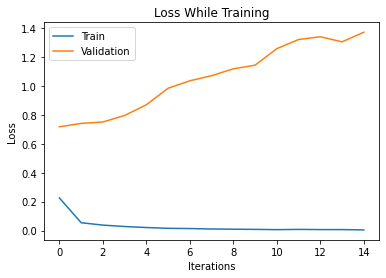

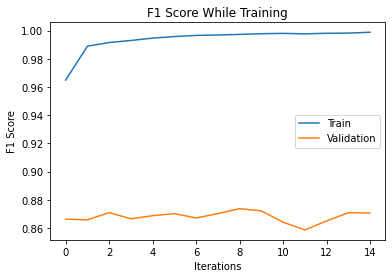

In [ ]:
model = train_SLRM(X, y, num_classes=NUM_CLASSES, epochs=15, plot=True, pre_dim=50, post_dim=50)

In [10]:
""" 
Now we attempt open-set classicfication by training a logistic regression model on k 
classes (digits 0-8 for this dataset) and test on k+1. If all predicted class probabilities
are below a threshold, predict the open set.
"""
    
def threshold_predict(X, model, threshold):
    y_pred = model.call(X)
    highest_prob = tf.reduce_max(y_pred, axis=1)
    return tf.where(highest_prob < threshold, -1, tf.argmax(y_pred, axis=1))

def modify_open_set_labels(y, open_set_class_labels):
    """Replaces class labels from the open set in y with -1
    """
    open_set_idx = tf.reduce_any([y == label for label in open_set_class_labels], axis=0)
    return tf.where(open_set_idx, -1, y)

def open_set_accuracy(y_true, y_pred):
    """ fraction of samples in the open set that are classified correctly.
    """
    y_true = tf.cast(y_true, tf.int64)
    open_set_idx = y_true == -1
    return accuracy(y_true[open_set_idx], y_pred[open_set_idx])

def open_set_f1_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int64)
    y_true = tf.where(y_true == -1, 1, 0)
    y_pred = tf.where(y_pred == -1, 1, 0)
    return f1_score(y_true, y_pred)
    
def known_fraction(y_pred):
    """Fraction of predicted class labels != -1"""
    return tf.reduce_sum(tf.cast(y_pred != -1, tf.int64)) / y_pred.shape

In [11]:
def tune_model_param(model, val_closed, val_open, param_values, param_name, predict_func,
                     objective_func, target_value, objective_name, metrics, plot=True):
    # convert instances of class labels in the open set to -1
    y_val_open = modify_open_set_labels(y_val, OPEN_SET_LABELS)
    best_objective_error = float('inf')
    best_param_value = 0
    objective_values = []
    metric_values = {metric: [] for metric in metrics}
    for param_value in param_values:
        y_pred_closed = predict_func(val_closed['X'], model, param_value)
        y_pred_open = predict_func(val_open['X'], model, param_value)
        objective_values.append(objective_func(y_pred_closed))
        objective_error = float(abs(objective_values[-1] - target_value))
        if objective_error < best_objective_error:
            best_objective_error = objective_error
            best_param_value = param_value
        for metric in metrics:
            metric_values[metric].append(metrics[metric](val_open['y'], y_pred_open))
    if plot:
        for metric in metrics:
            plt.plot(param_values, metric_values[metric], label=metric)
        plt.plot(param_values, objective_values, label=objective_name)
        plt.xlabel(param_name)
        plt.legend()
        plt.title('Calibrating {}'.format(param_name))
        plt.show()
    return best_param_value

In [12]:
# See how the threshold value affects accuracy and find the threshold
# such that 95% of validation data is recognized as known

tuning_metrics = {
    'All Class F1': lambda *x: f1_score(*x, average='macro'),
    'Open-Set F1': open_set_f1_score,
    'All Class Accuracy': accuracy,
    'Open-Set Accuracy': open_set_accuracy,    
}

def tune_TSLR_threshold(model, X_val, y_val, plot=True):
    """Tunes a Thresholded-Standard-Logistic-Regression model's threshold so
    that 95% of a closed-set validation set's samples are predicted to be
    from one of the known classes.
    """
    threshold_values = np.linspace(0, 1, 100)
    target_known_fraction = .95
    # split validation set into an open validation set and a closed validation set
    X_val_open, X_val_closed, y_val_open, y_val_closed = data_split(X_val, y_val, val_size=.5)
    # convert instances of class labels in the open set to -1
    y_val_open = modify_open_set_labels(y_val_open, OPEN_SET_LABELS)
    # remove open-set samples from the closed-set validation data
    X_val_closed, y_val_closed = remove_classes_from_dataset(X_val_closed, y_val_closed, OPEN_SET_LABELS)
    val_closed = {'X': X_val_closed, 'y': y_val_closed}
    val_open = {'X': X_val_open, 'y': y_val_open}
    param_name = 'Classification Probability Threshold'
    objective_name = 'Known Fraction'
    threshold = tune_model_param(
        model, val_closed, val_open, threshold_values, param_name, threshold_predict,
        known_fraction, target_known_fraction, objective_name, tuning_metrics, plot=plot
    )
    return threshold

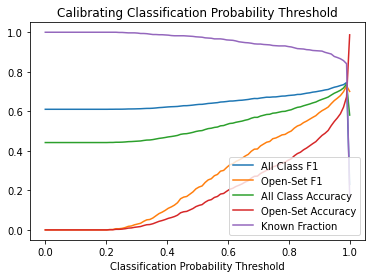

Results from test set using 95% threshold (0.6465):
All Class F1: 0.6564
Open-Set F1: 0.3756
All Class Accuracy: 0.5474
Open-Set Accuracy: 0.2437


In [ ]:
threshold = tune_TSLR_threshold(model, X_val, y_val)

# Evaluate on test set

# convert instances of class labels in the open set to -1
y_test_open = modify_open_set_labels(y_test, OPEN_SET_LABELS)

y_pred = threshold_predict(X_test, model, threshold)
print('Results from test set using 95% threshold ({:.4f}):'.format(threshold))
for metric in tuning_metrics:
    metric_func = tuning_metrics[metric]
    print('{}: {:.4f}'.format(metric, metric_func(y_test_open, y_pred)))

In [13]:
""" Now that we have a baseline, we will implement the placeholders algorithm.
"""

class OpenSetPlaceholdersLRM(StandardLogisticRegressionModel):
    def __init__(self, num_placeholders, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_placeholders = num_placeholders
        self.dummy_logits_layer = tf.keras.layers.Dense(num_placeholders, activation=None, name='dummy_logits')
        self.bias = 0 # used to calibrate dummy logit to have same magnitude as rest of logits

    def _pre(self, inputs):
        return self.embed_pre(inputs)
    
    def _rest(self, inputs):
        x_post = self.embed_post(inputs)
        closed_set_logits = self.logits_layer(x_post)
        dummy_logits = self.dummy_logits_layer(x_post)
        max_dummy_logit = tf.reduce_max(dummy_logits, axis=1)
        all_logits = tf.concat([closed_set_logits, tf.expand_dims(max_dummy_logit, 1) + self.bias], axis=1)
        return self.output_layer(all_logits)
        
    def call(self, inputs):
        x_pre = self._pre(inputs)
        return self._rest(x_pre)
        
    def predict(self, x):
        """ Returns the predicted class label. If predicted class is dummy class, return -1
        indicating prediction falls within the open set.
        """
        y_pred = self.call(x)
        y_pred_labels = tf.argmax(y_pred, axis=1)
        return tf.where(y_pred_labels == self.num_classes, -1, y_pred_labels)    
    
def ce_loss_for_placeholders(y_true, y_pred, beta):
    loss = ce_loss(y_true, y_pred)
    # set each sample's predicted probability for the true class to zero
    y_pred_without_true_prob = tf.where(y_true == 1, 0., y_pred)
    # create a new y_true where the true label is the dummy class
    rows, cols = y_true.shape
    rows = rows or 1
    y_true_dummy = tf.concat([tf.zeros([rows, cols - 1]), tf.ones([rows, 1])], axis=1)
    loss += beta * ce_loss(y_true_dummy, y_pred_without_true_prob)
    return loss

def train_OSPLRM(X, y, num_classes, beta=.5, epochs=25, plot=True, **kwargs):
    model = OpenSetPlaceholdersLRM(
        num_classes=num_classes,
        **kwargs
    )
    loss = lambda *x: ce_loss_for_placeholders(*x, beta)
    model.compile(
        optimizer='adam', 
        loss=loss, 
        metrics=[tfa.metrics.F1Score(name='f1', num_classes=num_classes+1, average='macro')]
    )
    # The "+ 1"s below add an additional column of zeros to the one-hot encodings for
    # the dummy class
    y_train_one_hot = tf.one_hot(tf.cast(y, tf.int64), depth=model.num_classes + 1)
    checkpoint_filepath = './tmp/checkpoint'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_f1',
        mode='max',
        save_best_only=True
    )
    history = model.fit(
        X, y_train_one_hot, epochs=epochs, validation_data=(X_val_closed, y_val_closed_one_hot_extra), 
        batch_size=32,callbacks=[model_checkpoint_callback]
    )
    model.load_weights(checkpoint_filepath)
    if plot:
        history = history.history
        plot_training_metric(history['loss'], history['val_loss'], 'Loss')
        plot_training_metric(history['f1'], history['val_f1'], 'F1 Score')
    return model

Epoch 1/15
1563/1563 [==============================] - 11s 7ms/step - loss: 1.4573 - f1: 0.8601 - val_loss: 1.8403 - val_f1: 0.7895
Epoch 2/15
1563/1563 [==============================] - 11s 7ms/step - loss: 1.2315 - f1: 0.9254 - val_loss: 1.8504 - val_f1: 0.7588
Epoch 3/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2129 - f1: 0.9369 - val_loss: 1.8383 - val_f1: 0.8271
Epoch 4/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2015 - f1: 0.9443 - val_loss: 1.8542 - val_f1: 0.8199
Epoch 5/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.1931 - f1: 0.9495 - val_loss: 1.8859 - val_f1: 0.8142
Epoch 6/15
1563/1563 [==============================] - 8s 5ms/step - loss: 1.1851 - f1: 0.9557 - val_loss: 1.9023 - val_f1: 0.8174
Epoch 7/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.1799 - f1: 0.9588 - val_loss: 1.9360 - val_f1: 0.8175
Epoch 8/15
1563/1563 [==============================] - 6s 4ms/step - loss

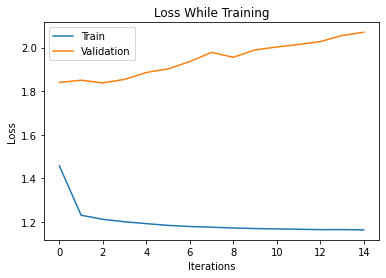

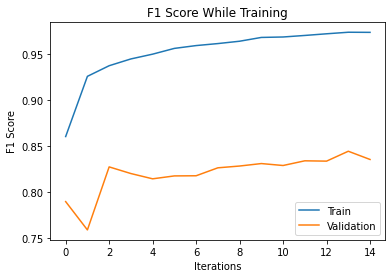

In [ ]:
# train for closed set classification on 0-8, 9 is removed before training
# from the train set, but is left in the valdation set

model = train_OSPLRM(
    X, y,
    num_classes=NUM_CLASSES,
    epochs=15,
    num_placeholders=20,
    pre_dim=50,
    post_dim=50,
    beta=.7,
    plot=True,
)

In [14]:
# See how the bias value affects accuracy and find the bias
# such that 95% of validation data is recognized as known

def tune_OSPLRM_threshold(model, X_val, y_val, plot=True):
    """Tunes a Open-Set-Placeholders-Logistic-Regression model's bias so
    that 95% of a closed-set validation set's samples are predicted to be
    from one of the known classes.
    """
    def placeholders_predict(X, model, bias):
        model.bias = bias
        return model.predict(X)

    target_known_fraction = .95
    bias_values = np.linspace(-2, 2, 100)
    # split validation set into an open validation set and a closed validation set
    X_val_open, X_val_closed, y_val_open, y_val_closed = data_split(X_val, y_val, val_size=.5)
    # convert instances of class labels in the open set to -1
    y_val_open = modify_open_set_labels(y_val_open, OPEN_SET_LABELS)
    # remove open-set samples from the closed-set validation data
    X_val_closed, y_val_closed = remove_classes_from_dataset(X_val_closed, y_val_closed, OPEN_SET_LABELS)
    val_closed = {'X': X_val_closed, 'y': y_val_closed}
    val_open = {'X': X_val_open, 'y': y_val_open}
    param_name = 'Dummy Classifier Bias'
    objective_name = 'Known Fraction'
    bias = tune_model_param(
        model, val_closed, val_open, bias_values, param_name, placeholders_predict,
        known_fraction, target_known_fraction, objective_name, tuning_metrics, plot=plot
    )
    return bias

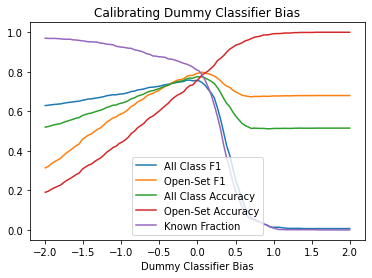

Results from test set using 95% bias (-1.3131):
All Class F1: 0.6813
Open-Set F1: 0.5040
All Class Accuracy: 0.6035
Open-Set Accuracy: 0.3583


In [ ]:
bias = tune_OSPLRM_threshold(model, X_val, y_val)
model.bias = bias

# Evaluate on test set

# convert instances of class labels in the open set to -1
y_test_open = modify_open_set_labels(y_test, OPEN_SET_LABELS)

y_pred = model.predict(X_test)
print('Results from test set using 95% bias ({:.4f}):'.format(bias))
for metric in tuning_metrics:
    metric_func = tuning_metrics[metric]
    print('{}: {:.4f}'.format(metric, metric_func(y_test_open, y_pred)))

In [15]:
### THE CODE BELOW IS A WORK IN PROGRESS AND DOES NOT CURRENTLY RUN ###


"""We will now introduce data placeholders. In essence, we will be synthesizing open-set training
data via a process called "manifold mixup". We will also introduce a new loss function which makes
use of the new synthetic data.
"""

# Open set placeholder
class OSPWithDataPlaceholdersLRM(OpenSetPlaceholdersLRM):
    def __init__(self, alpha, beta, gamma, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        
    def train_step(self, data):
        X, y = data
        X_part1, X_part2 = tf.split(X, 2)
        y_part1, y_part2 = tf.split(y, 2)
        # create a new y_true where the true label is the open-set class
        rows, cols = y_part2.shape
        rows = rows or 1
        y_part2_new = tf.concat([tf.zeros([rows, cols - 1]), tf.ones([rows, 1])], axis=1)
        
        with tf.GradientTape() as tape:
            # caldulate the first portion of the loss on the first half of the batch
            y_part1_pred = self.call(X_part1)
            loss1 = ce_loss_for_placeholders(y_part1, y_part1_pred, self.beta)
            # perform manifold mixup and calculate the second part of the loss
            X_part2_pre = self._pre(X_part2)
            X_part2_pre_hat = self.manifold_mixup(X_part2_pre)
            y_part2_pred = self._rest(X_part2_pre_hat)
            loss2 = ce_loss(y_part2_new, y_part2_pred)
            # calculated weighted sum of losses
            loss = loss1 + self.gamma * loss2
            
        # compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics using the predictions from batch part 1
        self.compiled_metrics.update_state(y_part1, y_part1_pred)
        results = {m.name: m.result() for m in self.metrics}
        results['loss'] = loss
        return results
    
    def manifold_mixup(self, X_pre):
        """
        """
        alpha = tf.constant(self.alpha)
        dist = tfp.distributions.Beta(alpha, alpha)
        lam = dist.sample(1)
        if not X_pre.shape[0]:
            return X_pre
        indices = tf.random.shuffle(tf.range(X_pre.shape[0]))
        X_pre_hat = lam * X_pre + (1 - lam) * tf.gather(X_pre, indices)
        return X_pre_hat

def train_OSPWDPLSM(X, y, num_classes, batch_size=64, epochs=25, plot=True, **kwargs):
    model = OSPWithDataPlaceholdersLRM(
        num_classes=num_classes,
        **kwargs
    )
    model.compile(
        optimizer='adam', 
        metrics=[tfa.metrics.F1Score(name='f1', num_classes=num_classes+1, average='macro')]
    )
    # The "+ 1"s below add an additional column of zeros to the one-hot encodings for
    # the dummy class
    y_train_one_hot = tf.one_hot(tf.cast(y, tf.int64), depth=model.num_classes + 1)
    checkpoint_filepath = './tmp/checkpoint'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_f1',
        mode='max',
        save_best_only=True
    )
    # ensure the length of the training dataset is a multiple of the batch_size
    num_train_samples = (X.shape[0] // batch_size) * batch_size
    X = X[:num_train_samples]
    y_train_one_hot = y_train_one_hot[:num_train_samples]
    history = model.fit(
        X, y_train_one_hot, epochs=epochs, validation_data=(X_val_closed, y_val_closed_one_hot_extra), 
        batch_size=batch_size, callbacks=[model_checkpoint_callback]
    )
    model.load_weights(checkpoint_filepath)
    if plot:
        history = history.history
        plot_training_metric(history['f1'], history['val_f1'], 'F1 Score')
        plt.plot(history['loss'])
        plt.title('Training Loss')
        plt.xlabel('epoch')
        plt.show()
    return model

Epoch 1/35
781/781 [==============================] - 6s 6ms/step - f1: 0.7673 - loss: 1.7440 - val_loss: 0.0000e+00 - val_f1: 0.6014
Epoch 2/35
781/781 [==============================] - 5s 6ms/step - f1: 0.8606 - loss: 1.3707 - val_loss: 0.0000e+00 - val_f1: 0.7510
Epoch 3/35
781/781 [==============================] - 5s 6ms/step - f1: 0.8706 - loss: 1.1961 - val_loss: 0.0000e+00 - val_f1: 0.7487
Epoch 4/35
781/781 [==============================] - 5s 6ms/step - f1: 0.8802 - loss: 1.2576 - val_loss: 0.0000e+00 - val_f1: 0.6655
Epoch 5/35
781/781 [==============================] - 5s 6ms/step - f1: 0.8803 - loss: 1.2140 - val_loss: 0.0000e+00 - val_f1: 0.7111
Epoch 6/35
781/781 [==============================] - 5s 7ms/step - f1: 0.8845 - loss: 1.2344 - val_loss: 0.0000e+00 - val_f1: 0.7622
Epoch 7/35
781/781 [==============================] - 5s 6ms/step - f1: 0.8918 - loss: 1.3467 - val_loss: 0.0000e+00 - val_f1: 0.7657
Epoch 8/35
781/781 [==============================] - 5s 6ms/s

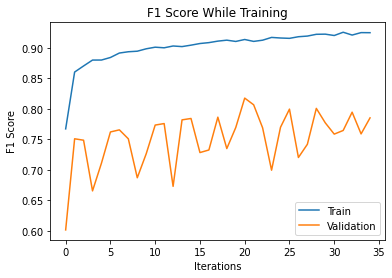

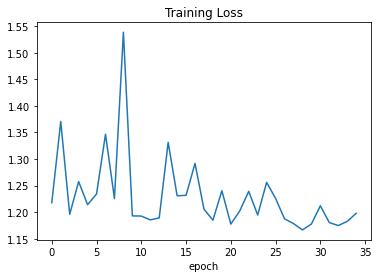

In [ ]:
# train for closed set classification on 0-8, 9 is removed before training
# from the train set, but is left in the valdation set

model = train_OSPWDPLSM(
    X, y,
    num_classes=NUM_CLASSES,
    epochs=35,
    num_placeholders=20,
    pre_dim=50,
    post_dim=50,
    alpha=2.0,
    beta=.7,
    gamma=.2,
    plot=True,
)

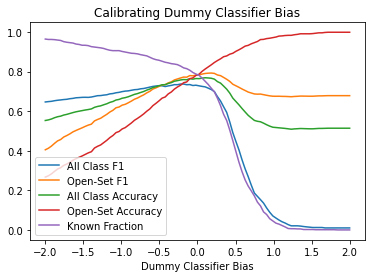

Results from test set using 95% bias (-1.7576):
All Class F1: 0.6762
Open-Set F1: 0.4681
All Class Accuracy: 0.5867
Open-Set Accuracy: 0.3253


In [ ]:
bias = tune_OSPLRM_threshold(model, X_val, y_val, OPEN_SET_LABELS)
model.bias = bias

# Evaluate on test set

# convert instances of class labels in the open set to -1
y_test_open = modify_open_set_labels(y_test, OPEN_SET_LABELS)

y_pred = model.predict(X_test)
print('Results from test set using 95% bias ({:.4f}):'.format(bias))
for metric in tuning_metrics:
    metric_func = tuning_metrics[metric]
    print('{}: {:.4f}'.format(metric, metric_func(y_test_open, y_pred)))

In [ ]:
"""We will now look at how well the various methods separate the image embeddings by learning a 
R^d -> R^2 embedding module and plotting the various class embedding clusters.
"""

# Standard Logistic Regression trained on closed set 0-8 (9 held out)

model = train_SLRM(
    X, y, 
    num_classes=NUM_CLASSES, 
    epochs=75, 
    plot=True, 
    pre_dim=50, 
    post_dim=2
)

In [ ]:
def plot_post_embeddings(model, X, y):
    X_pre = model.embed_pre(X)
    X_post = model.embed_post(X_pre)
    scatter = plt.scatter(X_post[:,0], X_post[:,1], c=y)
    plt.legend(*scatter.legend_elements(), loc='lower left', bbox_to_anchor=(1,0))
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Feature Embedding Space')
    plt.show()

plot_post_embeddings(model, X, y)
y_val_open = modify_open_set_labels(y_val, OPEN_SET_LABELS)
plot_post_embeddings(model, X_val, y_val_open)

In [ ]:
model = train_OSPLRM(
    X, y,
    num_classes=NUM_CLASSES,
    epochs=150,
    num_placeholders=20,
    pre_dim=50,
    post_dim=2,
    beta=.7,
    plot=True,
)

In [ ]:
plot_post_embeddings(model, X, y)
y_val_open = modify_open_set_labels(y_val, OPEN_SET_LABELS)
plot_post_embeddings(model, X_val, y_val_open)

In [ ]:
# train for closed set classification on 0-8, 9 is removed before training
# from the train set, but is left in the valdation set 

model = train_OSPWDPLSM(
    X, y,
    num_classes=NUM_CLASSES,
    epochs=150,
    num_placeholders=20,
    pre_dim=50,
    post_dim=2,
    alpha=2.0,
    beta=.7,
    gamma=.2,
    plot=True,
)

In [ ]:
plot_post_embeddings(model, X, y)
y_val_open = modify_open_set_labels(y_val, OPEN_SET_LABELS)
plot_post_embeddings(model, X_val, y_val_open)

# START POINT FOR FINE TUNING

--------------------------------------
######################################
-------------P_DIM VALUE 10 ---------------
######################################
--------------------------------------
Epoch 1/15
1563/1563 [==============================] - 7s 4ms/step - loss: 2.2934 - f1: 0.6406 - val_loss: 2.6719 - val_f1: 0.6822
Epoch 2/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.3868 - f1: 0.8691 - val_loss: 2.5135 - val_f1: 0.7161
Epoch 3/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.3396 - f1: 0.8910 - val_loss: 2.4352 - val_f1: 0.7545
Epoch 4/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.3158 - f1: 0.9019 - val_loss: 2.4115 - val_f1: 0.7643
Epoch 5/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2994 - f1: 0.9087 - val_loss: 2.3761 - val_f1: 0.7617
Epoch 6/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2874 - f1: 0.9141 - val_loss: 2.3803 - val_f1: 0.7477
Epoch 7/

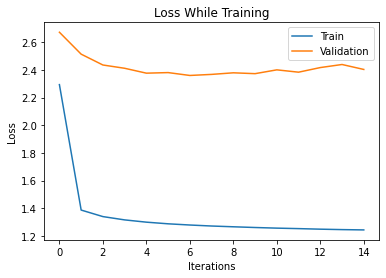

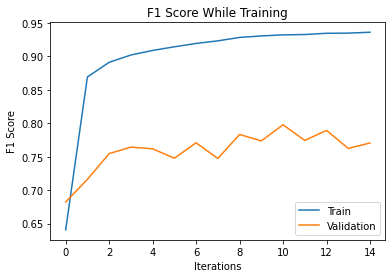

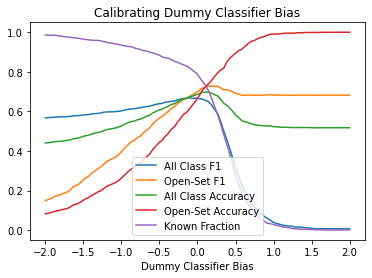

Results from test set using 95% bias (-1.1919):
0.6122256839715007
All Class F1: 0.6122
0.37221368178324366
Open-Set F1: 0.3722
tf.Tensor(0.52325, shape=(), dtype=float32)
All Class Accuracy: 0.5232
tf.Tensor(0.24328059, shape=(), dtype=float32)
Open-Set Accuracy: 0.2433
Epoch 1/35
781/781 [==============================] - 6s 6ms/step - f1: 0.2959 - loss: 3.3306 - val_loss: 0.0000e+00 - val_f1: 0.4721
Epoch 2/35
781/781 [==============================] - 5s 6ms/step - f1: 0.7805 - loss: 1.8382 - val_loss: 0.0000e+00 - val_f1: 0.6221
Epoch 3/35
781/781 [==============================] - 5s 6ms/step - f1: 0.8220 - loss: 1.8012 - val_loss: 0.0000e+00 - val_f1: 0.6414
Epoch 4/35
781/781 [==============================] - 5s 6ms/step - f1: 0.8362 - loss: 1.6351 - val_loss: 0.0000e+00 - val_f1: 0.6654
Epoch 5/35
781/781 [==============================] - 5s 6ms/step - f1: 0.8483 - loss: 1.2739 - val_loss: 0.0000e+00 - val_f1: 0.6776
Epoch 6/35
781/781 [==============================] - 5s 6

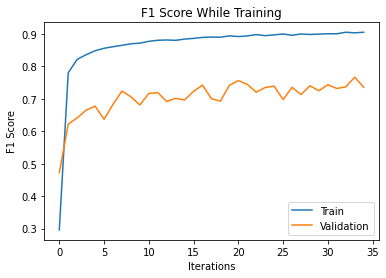

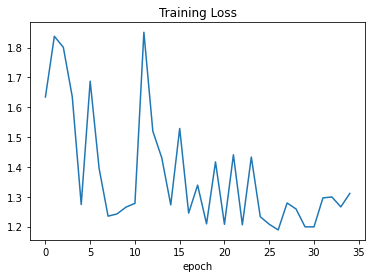

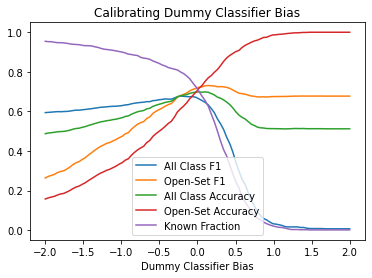

Results from test set using 95% bias (-1.8788):
0.5991001142556538
All Class F1: 0.5991
0.27322630761263594
Open-Set F1: 0.2732
tf.Tensor(0.490125, shape=(), dtype=float32)
All Class Accuracy: 0.4901
tf.Tensor(0.1656619, shape=(), dtype=float32)
Open-Set Accuracy: 0.1657
--------------------------------------
######################################
-------------P_DIM VALUE 25 ---------------
######################################
--------------------------------------
Epoch 1/15
1563/1563 [==============================] - 7s 4ms/step - loss: 1.6277 - f1: 0.8269 - val_loss: 2.0200 - val_f1: 0.7533
Epoch 2/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2551 - f1: 0.9218 - val_loss: 1.9972 - val_f1: 0.7818
Epoch 3/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2341 - f1: 0.9372 - val_loss: 1.9674 - val_f1: 0.7931
Epoch 4/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2203 - f1: 0.9456 - val_loss: 1.9543 - val_f1: 0.8097


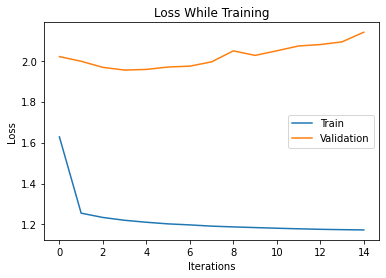

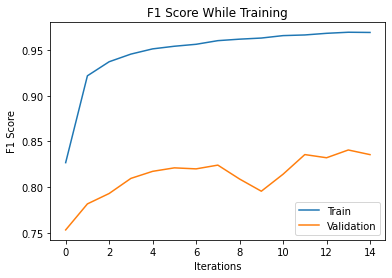

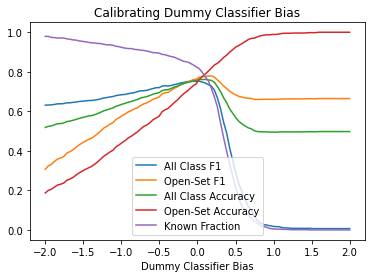

Results from test set using 95% bias (-1.4343):
0.6587260604850943
All Class F1: 0.6587
0.4319835790259377
Open-Set F1: 0.4320
tf.Tensor(0.566, shape=(), dtype=float32)
All Class Accuracy: 0.5660
tf.Tensor(0.29075608, shape=(), dtype=float32)
Open-Set Accuracy: 0.2908
Epoch 1/35
781/781 [==============================] - 6s 7ms/step - f1: 0.6903 - loss: 2.1149 - val_loss: 0.0000e+00 - val_f1: 0.6687
Epoch 2/35
781/781 [==============================] - 5s 7ms/step - f1: 0.8571 - loss: 1.2574 - val_loss: 0.0000e+00 - val_f1: 0.6712
Epoch 3/35
781/781 [==============================] - 5s 7ms/step - f1: 0.8722 - loss: 1.5505 - val_loss: 0.0000e+00 - val_f1: 0.7123
Epoch 4/35
781/781 [==============================] - 5s 7ms/step - f1: 0.8825 - loss: 1.6443 - val_loss: 0.0000e+00 - val_f1: 0.7311
Epoch 5/35
781/781 [==============================] - 5s 7ms/step - f1: 0.8895 - loss: 1.2156 - val_loss: 0.0000e+00 - val_f1: 0.7475
Epoch 6/35
781/781 [==============================] - 5s 7ms/

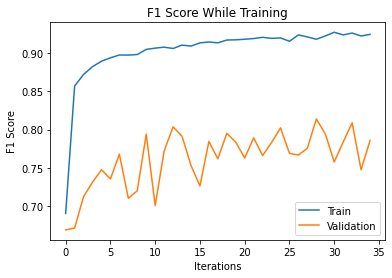

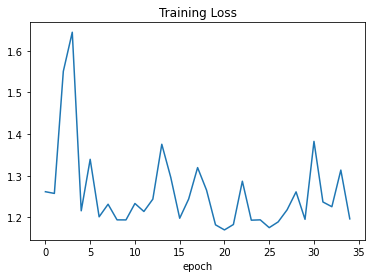

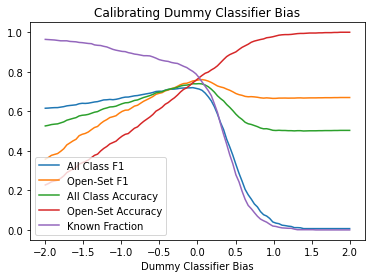

Results from test set using 95% bias (-1.5960):
0.6618021721541493
All Class F1: 0.6618
0.4509428805684613
Open-Set F1: 0.4509
tf.Tensor(0.57375, shape=(), dtype=float32)
All Class Accuracy: 0.5738
tf.Tensor(0.31085154, shape=(), dtype=float32)
Open-Set Accuracy: 0.3109
--------------------------------------
######################################
-------------P_DIM VALUE 50 ---------------
######################################
--------------------------------------
Epoch 1/15
1563/1563 [==============================] - 7s 4ms/step - loss: 1.4519 - f1: 0.8611 - val_loss: 1.9149 - val_f1: 0.7244
Epoch 2/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2319 - f1: 0.9255 - val_loss: 1.8946 - val_f1: 0.8079
Epoch 3/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2128 - f1: 0.9378 - val_loss: 1.8916 - val_f1: 0.8165
Epoch 4/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2007 - f1: 0.9452 - val_loss: 1.8943 - val_f1: 0.8218
E

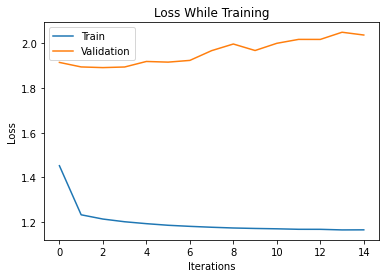

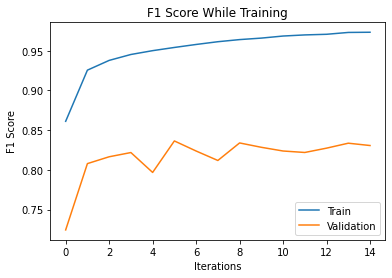

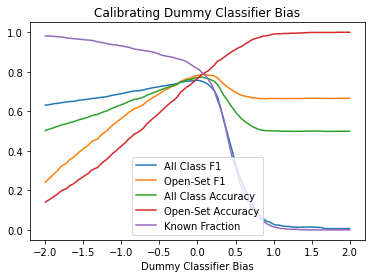

Results from test set using 95% bias (-1.2727):
0.6686524526246195
All Class F1: 0.6687
0.464867801521188
Open-Set F1: 0.4649
tf.Tensor(0.5834375, shape=(), dtype=float32)
All Class Accuracy: 0.5834
tf.Tensor(0.32240644, shape=(), dtype=float32)
Open-Set Accuracy: 0.3224
Epoch 1/35
781/781 [==============================] - 6s 7ms/step - f1: 0.7751 - loss: 1.7349 - val_loss: 0.0000e+00 - val_f1: 0.6698
Epoch 2/35
781/781 [==============================] - 5s 7ms/step - f1: 0.8614 - loss: 1.2180 - val_loss: 0.0000e+00 - val_f1: 0.7286
Epoch 3/35
781/781 [==============================] - 5s 7ms/step - f1: 0.8722 - loss: 1.2406 - val_loss: 0.0000e+00 - val_f1: 0.6441
Epoch 4/35
781/781 [==============================] - 5s 7ms/step - f1: 0.8783 - loss: 1.3254 - val_loss: 0.0000e+00 - val_f1: 0.7859
Epoch 5/35
781/781 [==============================] - 5s 7ms/step - f1: 0.8896 - loss: 1.1912 - val_loss: 0.0000e+00 - val_f1: 0.7530
Epoch 6/35
781/781 [==============================] - 5s 7

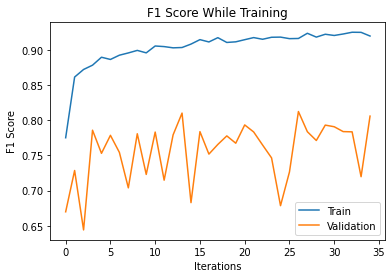

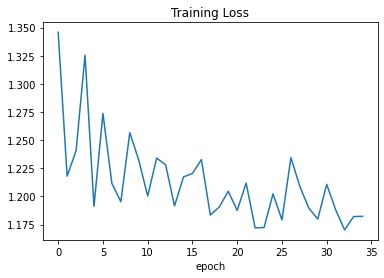

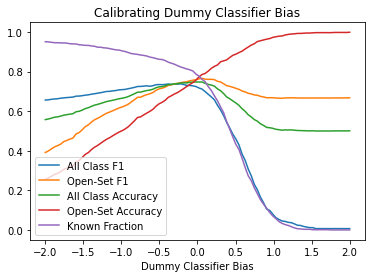

Results from test set using 95% bias (-1.9596):
0.6641263112430696
All Class F1: 0.6641
0.42993809791783905
Open-Set F1: 0.4299
tf.Tensor(0.5708125, shape=(), dtype=float32)
All Class Accuracy: 0.5708
tf.Tensor(0.28786737, shape=(), dtype=float32)
Open-Set Accuracy: 0.2879
--------------------------------------
######################################
-------------P_DIM VALUE 100 ---------------
######################################
--------------------------------------
Epoch 1/15
1563/1563 [==============================] - 7s 4ms/step - loss: 1.3736 - f1: 0.8740 - val_loss: 1.8421 - val_f1: 0.7928
Epoch 2/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2231 - f1: 0.9237 - val_loss: 1.8196 - val_f1: 0.7944
Epoch 3/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2044 - f1: 0.9366 - val_loss: 1.8283 - val_f1: 0.8207
Epoch 4/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.1921 - f1: 0.9442 - val_loss: 1.8422 - val_f1: 0.83

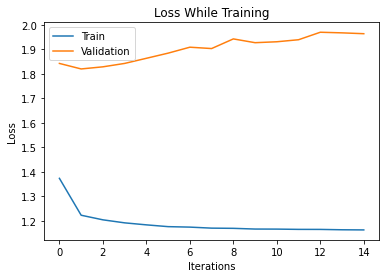

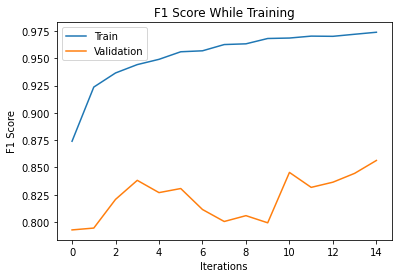

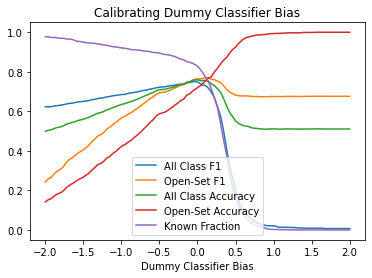

Results from test set using 95% bias (-1.5152):
0.6719579778158863
All Class F1: 0.6720
0.4276094276094276
Open-Set F1: 0.4276
tf.Tensor(0.572625, shape=(), dtype=float32)
All Class Accuracy: 0.5726
tf.Tensor(0.2871138, shape=(), dtype=float32)
Open-Set Accuracy: 0.2871
Epoch 1/35
781/781 [==============================] - 7s 7ms/step - f1: 0.7898 - loss: 1.5608 - val_loss: 0.0000e+00 - val_f1: 0.7226
Epoch 2/35
781/781 [==============================] - 5s 7ms/step - f1: 0.8488 - loss: 1.2218 - val_loss: 0.0000e+00 - val_f1: 0.6830
Epoch 3/35
781/781 [==============================] - 5s 7ms/step - f1: 0.8606 - loss: 1.2262 - val_loss: 0.0000e+00 - val_f1: 0.6412
Epoch 4/35
781/781 [==============================] - 5s 7ms/step - f1: 0.8648 - loss: 1.3241 - val_loss: 0.0000e+00 - val_f1: 0.7609
Epoch 5/35
781/781 [==============================] - 5s 7ms/step - f1: 0.8754 - loss: 1.2088 - val_loss: 0.0000e+00 - val_f1: 0.7466
Epoch 6/35
781/781 [==============================] - 5s 7m

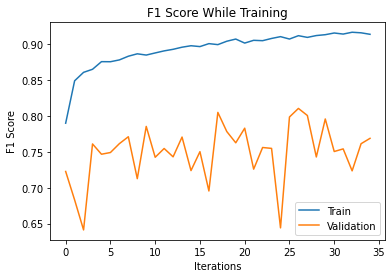

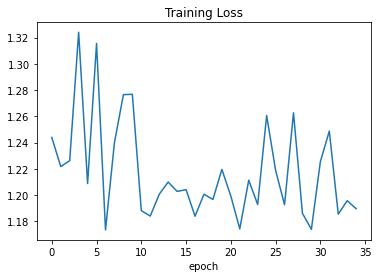

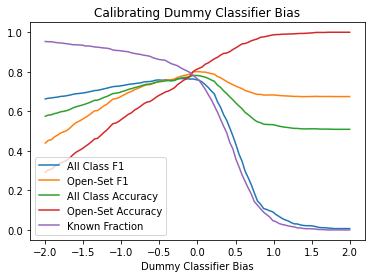

Results from test set using 95% bias (-1.8788):
0.6798700223215353
All Class F1: 0.6799
0.4677096598144443
Open-Set F1: 0.4677
tf.Tensor(0.590375, shape=(), dtype=float32)
All Class Accuracy: 0.5904
tf.Tensor(0.32290882, shape=(), dtype=float32)
Open-Set Accuracy: 0.3229
--------------------------------------
######################################
-------------P_DIM VALUE 300 ---------------
######################################
--------------------------------------
Epoch 1/15
1563/1563 [==============================] - 7s 4ms/step - loss: 1.3326 - f1: 0.8718 - val_loss: 1.8119 - val_f1: 0.7404
Epoch 2/15
1563/1563 [==============================] - 7s 4ms/step - loss: 1.2250 - f1: 0.9144 - val_loss: 1.7978 - val_f1: 0.7343
Epoch 3/15
1563/1563 [==============================] - 7s 4ms/step - loss: 1.2048 - f1: 0.9289 - val_loss: 1.8185 - val_f1: 0.8108
Epoch 4/15
1563/1563 [==============================] - 7s 4ms/step - loss: 1.1952 - f1: 0.9366 - val_loss: 1.8531 - val_f1: 0.7510

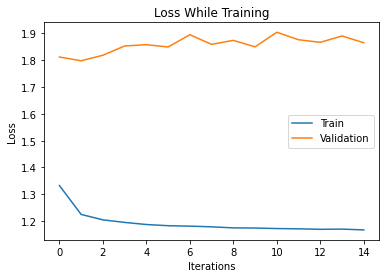

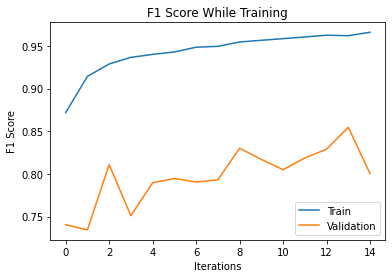

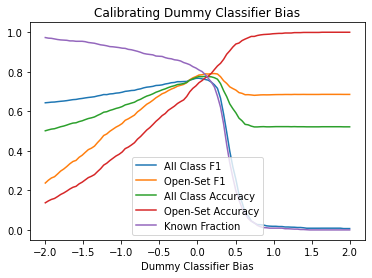

Results from test set using 95% bias (-1.4343):
0.6743619962056654
All Class F1: 0.6744
0.4318501170960188
Open-Set F1: 0.4319
tf.Tensor(0.575125, shape=(), dtype=float32)
All Class Accuracy: 0.5751
tf.Tensor(0.28950012, shape=(), dtype=float32)
Open-Set Accuracy: 0.2895
Epoch 1/35
781/781 [==============================] - 7s 8ms/step - f1: 0.7903 - loss: 1.4795 - val_loss: 0.0000e+00 - val_f1: 0.5779
Epoch 2/35
781/781 [==============================] - 6s 7ms/step - f1: 0.8340 - loss: 1.2231 - val_loss: 0.0000e+00 - val_f1: 0.7084
Epoch 3/35
781/781 [==============================] - 6s 7ms/step - f1: 0.8454 - loss: 1.2370 - val_loss: 0.0000e+00 - val_f1: 0.6240
Epoch 4/35
781/781 [==============================] - 6s 7ms/step - f1: 0.8498 - loss: 1.4454 - val_loss: 0.0000e+00 - val_f1: 0.6989
Epoch 5/35
781/781 [==============================] - 6s 7ms/step - f1: 0.8556 - loss: 1.3916 - val_loss: 0.0000e+00 - val_f1: 0.6857
Epoch 6/35
781/781 [==============================] - 6s 7

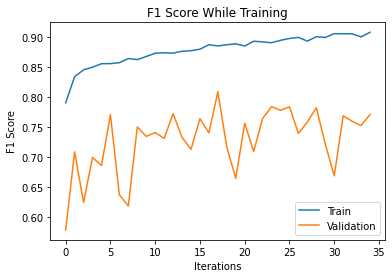

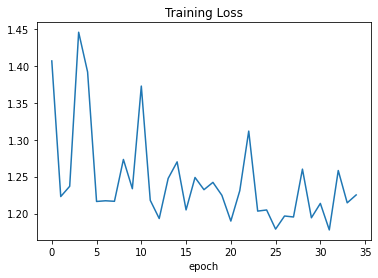

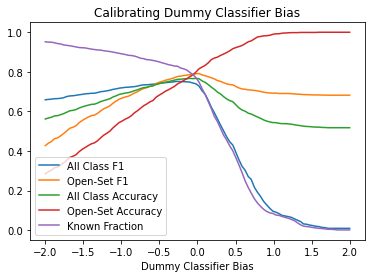

Results from test set using 95% bias (-1.9596):
0.6748232814287206
All Class F1: 0.6748
0.4267492027762147
Open-Set F1: 0.4267
tf.Tensor(0.5726875, shape=(), dtype=float32)
All Class Accuracy: 0.5727
tf.Tensor(0.28573224, shape=(), dtype=float32)
Open-Set Accuracy: 0.2857


In [ ]:
metric_train_OSPLRM = {"All Class F1":[], "Open-Set F1":[], "All Class Accuracy":[], "Open-Set Accuracy":[]}
metric_train_OSPWDPLSM = {"All Class F1":[], "Open-Set F1":[], "All Class Accuracy":[], "Open-Set Accuracy":[]}


for p_dim in [10, 25, 50, 100, 300]:

  print("--------------------------------------")
  print("######################################")
  print('-------------P_DIM VALUE {} ---------------'.format(p_dim))
  print("######################################")
  print("--------------------------------------")
  model = train_OSPLRM(
      X, y,
      num_classes=NUM_CLASSES,
      epochs=15,
      num_placeholders=20,
      pre_dim=p_dim,
      post_dim=p_dim,
      beta=.7,
      plot=True,
  )

  bias = tune_OSPLRM_threshold(model, X_val, y_val)
  model.bias = bias

  # Evaluate on test set

  # convert instances of class labels in the open set to -1
  y_test_open = modify_open_set_labels(y_test, OPEN_SET_LABELS)

  y_pred = model.predict(X_test)
  print('Results from test set using 95% bias ({:.4f}):'.format(bias))
  for metric in tuning_metrics:
      metric_func = tuning_metrics[metric]
      valueOfMetric = metric_func(y_test_open, y_pred)
      print(valueOfMetric)
      metric_train_OSPLRM[metric].append(valueOfMetric)
      print('{}: {:.4f}'.format(metric, valueOfMetric))



  # ----------------------------------- #



  model = train_OSPWDPLSM(
      X, y,
      num_classes=NUM_CLASSES,
      epochs=35,
      num_placeholders=20,
      pre_dim=p_dim,
      post_dim=p_dim,
      alpha=2.0,
      beta=.7,
      gamma=.2,
      plot=True,
  )


  bias = tune_OSPLRM_threshold(model, X_val, y_val, OPEN_SET_LABELS)
  model.bias = bias


  y_test_open = modify_open_set_labels(y_test, OPEN_SET_LABELS)

  y_pred = model.predict(X_test)
  print('Results from test set using 95% bias ({:.4f}):'.format(bias))
  for metric in tuning_metrics:
      metric_func = tuning_metrics[metric]
      valueOfMetric = metric_func(y_test_open, y_pred)
      print(valueOfMetric)
      metric_train_OSPWDPLSM[metric].append(valueOfMetric)
      print('{}: {:.4f}'.format(metric, valueOfMetric))






In [ ]:
print(metric_train_OSPLRM)
print(metric_train_OSPWDPLSM)
print("\n----------------------------\n")
headers = [10, 25, 50, 100, 300]
print(f'{"Score Type": <20}{headers[0]: <20}{headers[1]: <20}{headers[2]: <20}{headers[3]: <20}{headers[4]: <20}')
for key, value in metric_train_OSPLRM.items():
    print(f'{key: <20}{value[0]: <20}{value[1]: <20}{value[2]: <20}{value[3]: <20}{value[4]: <20}')

print("\n\n")
print(f'{"Score Type": <20}{headers[0]: <20}{headers[1]: <20}{headers[2]: <20}{headers[3]: <20}{headers[4]: <20}')
for key, value in metric_train_OSPWDPLSM.items():
    print(f'{key: <20}{value[0]: <20}{value[1]: <20}{value[2]: <20}{value[3]: <20}{value[4]: <20}')

{'All Class F1': [0.6122256839715007, 0.6587260604850943, 0.6686524526246195, 0.6719579778158863, 0.6743619962056654], 'Open-Set F1': [0.37221368178324366, 0.4319835790259377, 0.464867801521188, 0.4276094276094276, 0.4318501170960188], 'All Class Accuracy': [<tf.Tensor: shape=(), dtype=float32, numpy=0.52325>, <tf.Tensor: shape=(), dtype=float32, numpy=0.566>, <tf.Tensor: shape=(), dtype=float32, numpy=0.5834375>, <tf.Tensor: shape=(), dtype=float32, numpy=0.572625>, <tf.Tensor: shape=(), dtype=float32, numpy=0.575125>], 'Open-Set Accuracy': [<tf.Tensor: shape=(), dtype=float32, numpy=0.24328059>, <tf.Tensor: shape=(), dtype=float32, numpy=0.29075608>, <tf.Tensor: shape=(), dtype=float32, numpy=0.32240644>, <tf.Tensor: shape=(), dtype=float32, numpy=0.2871138>, <tf.Tensor: shape=(), dtype=float32, numpy=0.28950012>]}
{'All Class F1': [0.5991001142556538, 0.6618021721541493, 0.6641263112430696, 0.6798700223215353, 0.6748232814287206], 'Open-Set F1': [0.27322630761263594, 0.4509428805684

--------------------------------------
######################################
-------------PLACEHOLDER VALUE 1 ---------------
######################################
--------------------------------------
Epoch 1/15
1563/1563 [==============================] - 7s 4ms/step - loss: 1.3302 - f1: 0.8736 - val_loss: 1.8112 - val_f1: 0.7311
Epoch 2/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2257 - f1: 0.9160 - val_loss: 1.8045 - val_f1: 0.7224
Epoch 3/15
1563/1563 [==============================] - 7s 5ms/step - loss: 1.2061 - f1: 0.9279 - val_loss: 1.8261 - val_f1: 0.7721
Epoch 4/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.1928 - f1: 0.9355 - val_loss: 1.8103 - val_f1: 0.8079
Epoch 5/15
1563/1563 [==============================] - 8s 5ms/step - loss: 1.1875 - f1: 0.9402 - val_loss: 1.8429 - val_f1: 0.8120
Epoch 6/15
1563/1563 [==============================] - 7s 5ms/step - loss: 1.1819 - f1: 0.9446 - val_loss: 1.8464 - val_f1: 0.7636
Epo

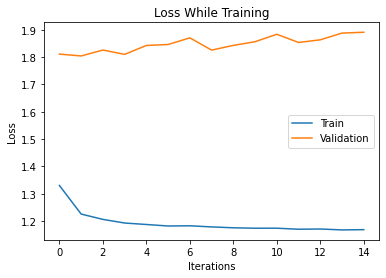

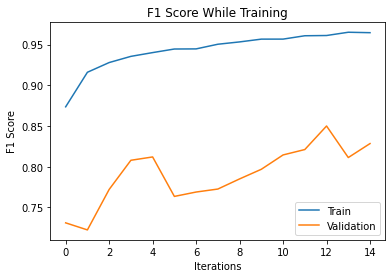

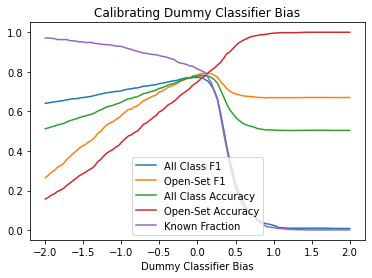

Results from test set using 95% bias (-1.5556):
0.6739395141555014
All Class F1: 0.6739
0.42721011416171334
Open-Set F1: 0.4272
tf.Tensor(0.5725, shape=(), dtype=float32)
All Class Accuracy: 0.5725
tf.Tensor(0.28435066, shape=(), dtype=float32)
Open-Set Accuracy: 0.2844
Epoch 1/35
781/781 [==============================] - 6s 6ms/step - f1: 0.7885 - loss: 1.5836 - val_loss: 0.0000e+00 - val_f1: 0.6968
Epoch 2/35
781/781 [==============================] - 5s 6ms/step - f1: 0.8505 - loss: 1.1973 - val_loss: 0.0000e+00 - val_f1: 0.6929
Epoch 3/35
781/781 [==============================] - 5s 6ms/step - f1: 0.8616 - loss: 1.2084 - val_loss: 0.0000e+00 - val_f1: 0.7720
Epoch 4/35
781/781 [==============================] - 5s 6ms/step - f1: 0.8690 - loss: 1.2676 - val_loss: 0.0000e+00 - val_f1: 0.7462
Epoch 5/35
781/781 [==============================] - 5s 6ms/step - f1: 0.8738 - loss: 1.1941 - val_loss: 0.0000e+00 - val_f1: 0.6967
Epoch 6/35
781/781 [==============================] - 5s 6m

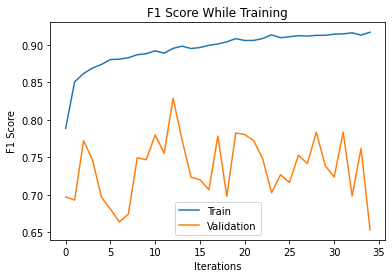

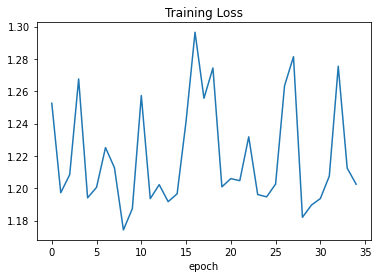

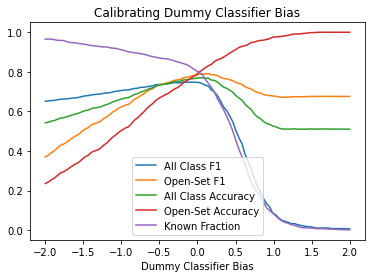

Results from test set using 95% bias (-1.6768):
0.6754276244778793
All Class F1: 0.6754
0.4602126879354602
Open-Set F1: 0.4602
tf.Tensor(0.583875, shape=(), dtype=float32)
All Class Accuracy: 0.5839
tf.Tensor(0.31524742, shape=(), dtype=float32)
Open-Set Accuracy: 0.3152
--------------------------------------
######################################
-------------PLACEHOLDER VALUE 5 ---------------
######################################
--------------------------------------
Epoch 1/15
1563/1563 [==============================] - 7s 4ms/step - loss: 1.3299 - f1: 0.8717 - val_loss: 1.8130 - val_f1: 0.7593
Epoch 2/15
1563/1563 [==============================] - 7s 4ms/step - loss: 1.2242 - f1: 0.9182 - val_loss: 1.7947 - val_f1: 0.7614
Epoch 3/15
1563/1563 [==============================] - 7s 4ms/step - loss: 1.2050 - f1: 0.9267 - val_loss: 1.7885 - val_f1: 0.8075
Epoch 4/15
1563/1563 [==============================] - 7s 4ms/step - loss: 1.1932 - f1: 0.9341 - val_loss: 1.8366 - val_f1: 0.

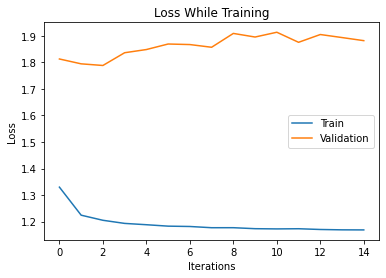

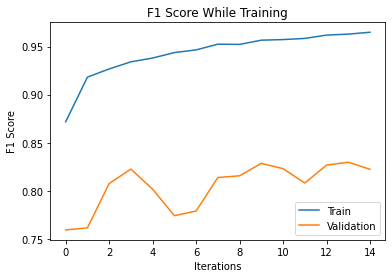

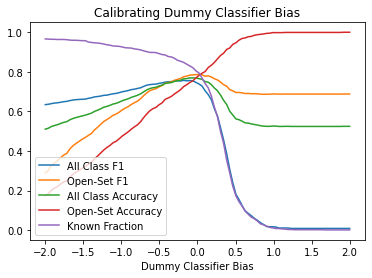

Results from test set using 95% bias (-1.4343):
0.6797541689401274
All Class F1: 0.6798
0.463347921225383
Open-Set F1: 0.4633
tf.Tensor(0.5885, shape=(), dtype=float32)
All Class Accuracy: 0.5885
tf.Tensor(0.3191409, shape=(), dtype=float32)
Open-Set Accuracy: 0.3191
Epoch 1/35
781/781 [==============================] - 6s 7ms/step - f1: 0.7880 - loss: 1.5914 - val_loss: 0.0000e+00 - val_f1: 0.6223
Epoch 2/35
781/781 [==============================] - 5s 7ms/step - f1: 0.8473 - loss: 1.2730 - val_loss: 0.0000e+00 - val_f1: 0.6707
Epoch 3/35
781/781 [==============================] - 5s 7ms/step - f1: 0.8631 - loss: 1.3415 - val_loss: 0.0000e+00 - val_f1: 0.7483
Epoch 4/35
781/781 [==============================] - 5s 7ms/step - f1: 0.8684 - loss: 1.2270 - val_loss: 0.0000e+00 - val_f1: 0.7705
Epoch 5/35
781/781 [==============================] - 5s 7ms/step - f1: 0.8740 - loss: 1.2578 - val_loss: 0.0000e+00 - val_f1: 0.6535
Epoch 6/35
781/781 [==============================] - 5s 7ms/s

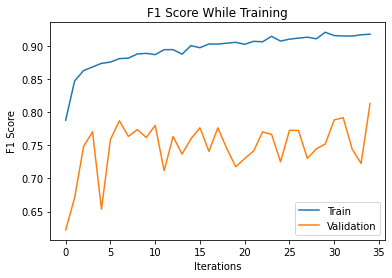

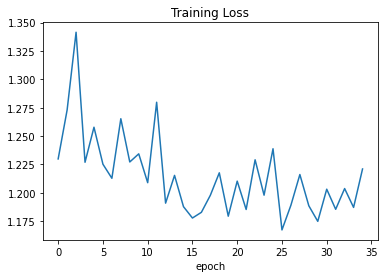

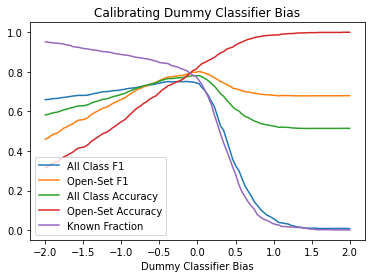

Results from test set using 95% bias (-2.0000):
0.6826203710913065
All Class F1: 0.6826
0.4710698689956332
Open-Set F1: 0.4711
tf.Tensor(0.593, shape=(), dtype=float32)
All Class Accuracy: 0.5930
tf.Tensor(0.32516956, shape=(), dtype=float32)
Open-Set Accuracy: 0.3252
--------------------------------------
######################################
-------------PLACEHOLDER VALUE 10 ---------------
######################################
--------------------------------------
Epoch 1/15
1563/1563 [==============================] - 8s 4ms/step - loss: 1.3256 - f1: 0.8730 - val_loss: 1.7949 - val_f1: 0.7634
Epoch 2/15
1563/1563 [==============================] - 7s 4ms/step - loss: 1.2238 - f1: 0.9169 - val_loss: 1.7890 - val_f1: 0.7753
Epoch 3/15
1563/1563 [==============================] - 7s 4ms/step - loss: 1.2045 - f1: 0.9274 - val_loss: 1.8280 - val_f1: 0.8162
Epoch 4/15
1563/1563 [==============================] - 7s 4ms/step - loss: 1.1936 - f1: 0.9341 - val_loss: 1.8141 - val_f1: 0.81

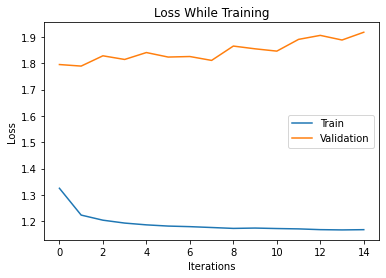

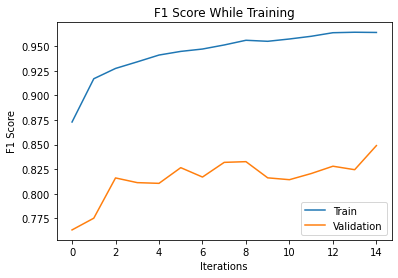

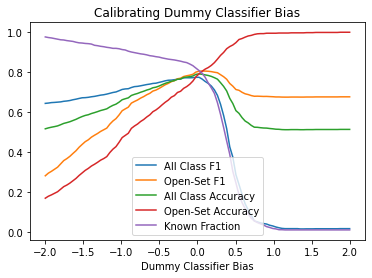

Results from test set using 95% bias (-1.5960):
0.6732889598129842
All Class F1: 0.6733
0.4287185247589629
Open-Set F1: 0.4287
tf.Tensor(0.5719375, shape=(), dtype=float32)
All Class Accuracy: 0.5719
tf.Tensor(0.28761616, shape=(), dtype=float32)
Open-Set Accuracy: 0.2876
Epoch 1/35
781/781 [==============================] - 7s 7ms/step - f1: 0.7955 - loss: 1.5633 - val_loss: 0.0000e+00 - val_f1: 0.7010
Epoch 2/35
781/781 [==============================] - 5s 7ms/step - f1: 0.8508 - loss: 1.2611 - val_loss: 0.0000e+00 - val_f1: 0.7220
Epoch 3/35
781/781 [==============================] - 5s 7ms/step - f1: 0.8620 - loss: 1.3803 - val_loss: 0.0000e+00 - val_f1: 0.7625
Epoch 4/35
781/781 [==============================] - 6s 7ms/step - f1: 0.8702 - loss: 1.2111 - val_loss: 0.0000e+00 - val_f1: 0.7303
Epoch 5/35
781/781 [==============================] - 5s 7ms/step - f1: 0.8758 - loss: 1.2504 - val_loss: 0.0000e+00 - val_f1: 0.7301
Epoch 6/35
781/781 [==============================] - 5s 

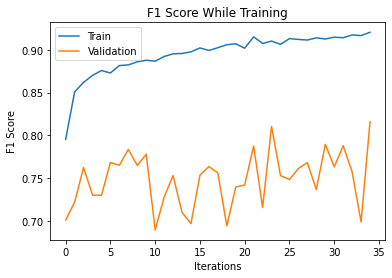

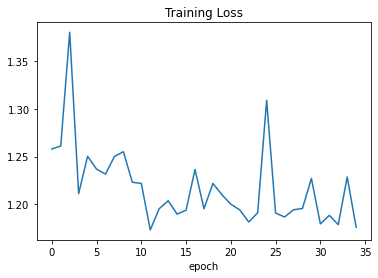

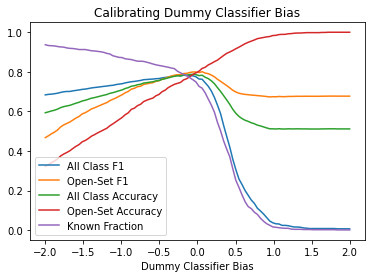

Results from test set using 95% bias (-2.0000):
0.6812698543212126
All Class F1: 0.6813
0.47318611987381703
Open-Set F1: 0.4732
tf.Tensor(0.592625, shape=(), dtype=float32)
All Class Accuracy: 0.5926
tf.Tensor(0.32969102, shape=(), dtype=float32)
Open-Set Accuracy: 0.3297
--------------------------------------
######################################
-------------PLACEHOLDER VALUE 25 ---------------
######################################
--------------------------------------
Epoch 1/15
1563/1563 [==============================] - 8s 5ms/step - loss: 1.3300 - f1: 0.8730 - val_loss: 1.7748 - val_f1: 0.7725
Epoch 2/15
1563/1563 [==============================] - 7s 4ms/step - loss: 1.2225 - f1: 0.9188 - val_loss: 1.7901 - val_f1: 0.8017
Epoch 3/15
1563/1563 [==============================] - 7s 4ms/step - loss: 1.2064 - f1: 0.9263 - val_loss: 1.8119 - val_f1: 0.8157
Epoch 4/15
1563/1563 [==============================] - 7s 4ms/step - loss: 1.1933 - f1: 0.9369 - val_loss: 1.8490 - val_f1: 

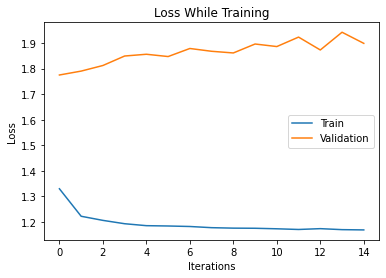

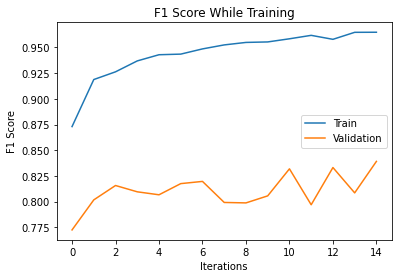

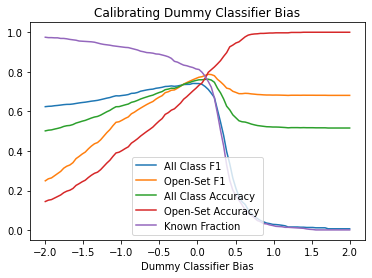

Results from test set using 95% bias (-1.3939):
0.6676506054563041
All Class F1: 0.6677
0.39630271519352983
Open-Set F1: 0.3963
tf.Tensor(0.5598125, shape=(), dtype=float32)
All Class Accuracy: 0.5598
tf.Tensor(0.25847778, shape=(), dtype=float32)
Open-Set Accuracy: 0.2585
Epoch 1/35
781/781 [==============================] - 7s 7ms/step - f1: 0.7879 - loss: 1.5674 - val_loss: 0.0000e+00 - val_f1: 0.7383
Epoch 2/35
781/781 [==============================] - 5s 7ms/step - f1: 0.8525 - loss: 1.2823 - val_loss: 0.0000e+00 - val_f1: 0.7096
Epoch 3/35
781/781 [==============================] - 6s 7ms/step - f1: 0.8589 - loss: 1.1841 - val_loss: 0.0000e+00 - val_f1: 0.6458
Epoch 4/35
781/781 [==============================] - 6s 7ms/step - f1: 0.8713 - loss: 1.2271 - val_loss: 0.0000e+00 - val_f1: 0.6847
Epoch 5/35
781/781 [==============================] - 6s 7ms/step - f1: 0.8702 - loss: 1.2201 - val_loss: 0.0000e+00 - val_f1: 0.7079
Epoch 6/35
781/781 [==============================] - 5s

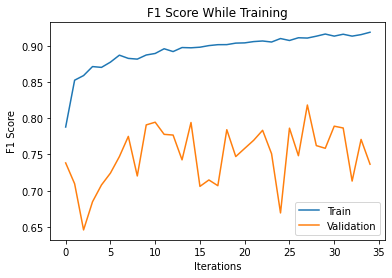

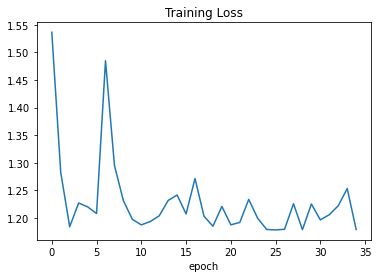

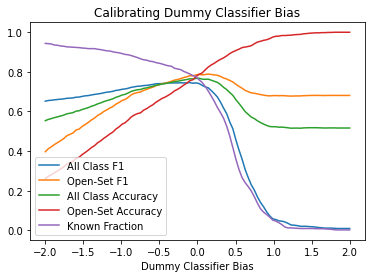

Results from test set using 95% bias (-2.0000):
0.6668445130341702
All Class F1: 0.6668
0.4212106992022524
Open-Set F1: 0.4212
tf.Tensor(0.5696875, shape=(), dtype=float32)
All Class Accuracy: 0.5697
tf.Tensor(0.28183874, shape=(), dtype=float32)
Open-Set Accuracy: 0.2818
--------------------------------------
######################################
-------------PLACEHOLDER VALUE 50 ---------------
######################################
--------------------------------------
Epoch 1/15
1563/1563 [==============================] - 8s 5ms/step - loss: 1.3249 - f1: 0.8750 - val_loss: 1.8116 - val_f1: 0.7580
Epoch 2/15
1563/1563 [==============================] - 7s 5ms/step - loss: 1.2240 - f1: 0.9158 - val_loss: 1.8013 - val_f1: 0.7574
Epoch 3/15
1563/1563 [==============================] - 7s 5ms/step - loss: 1.2031 - f1: 0.9301 - val_loss: 1.7945 - val_f1: 0.7985
Epoch 4/15
1563/1563 [==============================] - 7s 5ms/step - loss: 1.1916 - f1: 0.9382 - val_loss: 1.8190 - val_f1: 

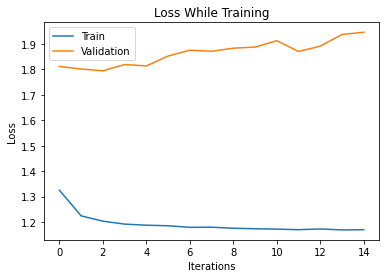

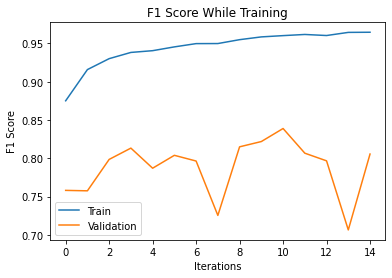

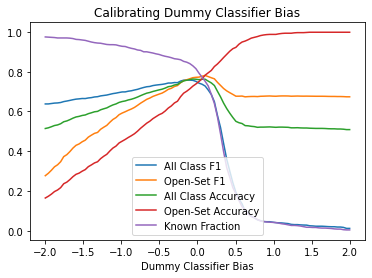

Results from test set using 95% bias (-1.3939):
0.6834690942905697
All Class F1: 0.6835
0.47550928021729283
Open-Set F1: 0.4755
tf.Tensor(0.593, shape=(), dtype=float32)
All Class Accuracy: 0.5930
tf.Tensor(0.32981664, shape=(), dtype=float32)
Open-Set Accuracy: 0.3298
Epoch 1/35
781/781 [==============================] - 7s 8ms/step - f1: 0.7946 - loss: 1.5664 - val_loss: 0.0000e+00 - val_f1: 0.6861
Epoch 2/35
781/781 [==============================] - 6s 7ms/step - f1: 0.8527 - loss: 1.2293 - val_loss: 0.0000e+00 - val_f1: 0.6330
Epoch 3/35
781/781 [==============================] - 6s 7ms/step - f1: 0.8661 - loss: 1.2060 - val_loss: 0.0000e+00 - val_f1: 0.7421
Epoch 4/35
781/781 [==============================] - 6s 7ms/step - f1: 0.8691 - loss: 1.5924 - val_loss: 0.0000e+00 - val_f1: 0.7737
Epoch 5/35
781/781 [==============================] - 6s 8ms/step - f1: 0.8753 - loss: 1.2498 - val_loss: 0.0000e+00 - val_f1: 0.7515
Epoch 6/35
781/781 [==============================] - 6s 7ms

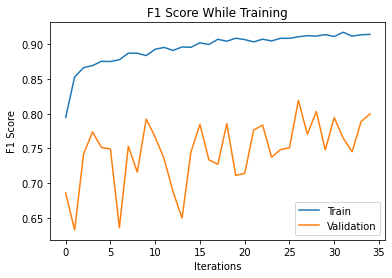

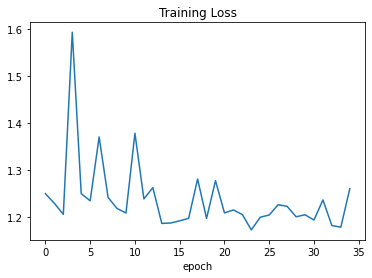

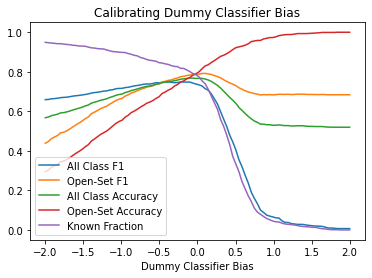

Results from test set using 95% bias (-2.0000):
0.671633851758329
All Class F1: 0.6716
0.4426002766251729
Open-Set F1: 0.4426
tf.Tensor(0.577875, shape=(), dtype=float32)
All Class Accuracy: 0.5779
tf.Tensor(0.3014318, shape=(), dtype=float32)
Open-Set Accuracy: 0.3014
--------------------------------------
######################################
-------------PLACEHOLDER VALUE 100 ---------------
######################################
--------------------------------------
Epoch 1/15
1563/1563 [==============================] - 8s 5ms/step - loss: 1.3277 - f1: 0.8733 - val_loss: 1.7942 - val_f1: 0.7155
Epoch 2/15
1563/1563 [==============================] - 7s 5ms/step - loss: 1.2237 - f1: 0.9168 - val_loss: 1.8044 - val_f1: 0.8210
Epoch 3/15
1563/1563 [==============================] - 7s 5ms/step - loss: 1.2046 - f1: 0.9285 - val_loss: 1.8295 - val_f1: 0.7410
Epoch 4/15
1563/1563 [==============================] - 7s 5ms/step - loss: 1.1938 - f1: 0.9347 - val_loss: 1.8192 - val_f1: 0.

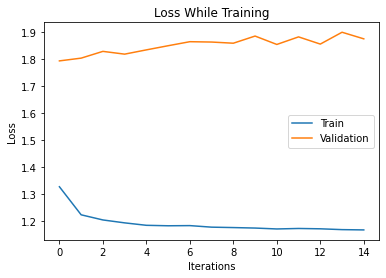

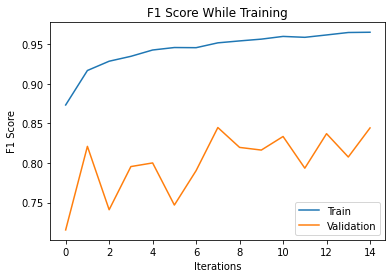

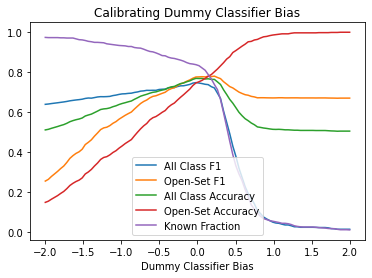

Results from test set using 95% bias (-1.3535):
0.6831482811812081
All Class F1: 0.6831
0.47694406548431106
Open-Set F1: 0.4769
tf.Tensor(0.594625, shape=(), dtype=float32)
All Class Accuracy: 0.5946
tf.Tensor(0.32931423, shape=(), dtype=float32)
Open-Set Accuracy: 0.3293
Epoch 1/35
781/781 [==============================] - 7s 8ms/step - f1: 0.7989 - loss: 1.5595 - val_loss: 0.0000e+00 - val_f1: 0.5948
Epoch 2/35
781/781 [==============================] - 6s 7ms/step - f1: 0.8527 - loss: 1.3784 - val_loss: 0.0000e+00 - val_f1: 0.7312
Epoch 3/35
781/781 [==============================] - 6s 8ms/step - f1: 0.8605 - loss: 1.4437 - val_loss: 0.0000e+00 - val_f1: 0.5844
Epoch 4/35
781/781 [==============================] - 6s 8ms/step - f1: 0.8679 - loss: 1.2758 - val_loss: 0.0000e+00 - val_f1: 0.7523
Epoch 5/35
781/781 [==============================] - 6s 7ms/step - f1: 0.8765 - loss: 1.4272 - val_loss: 0.0000e+00 - val_f1: 0.7586
Epoch 6/35
781/781 [==============================] - 6s 

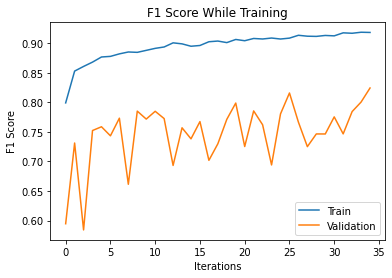

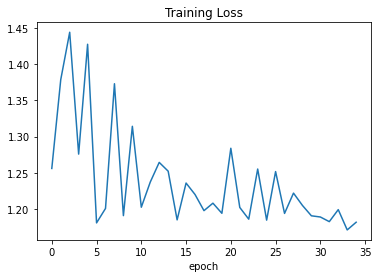

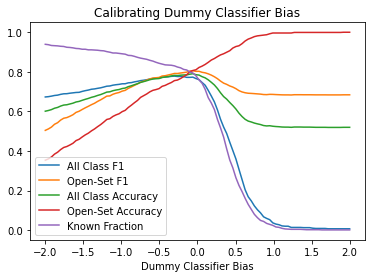

Results from test set using 95% bias (-2.0000):
0.6821103455950909
All Class F1: 0.6821
0.4895554365291912
Open-Set F1: 0.4896
tf.Tensor(0.5990625, shape=(), dtype=float32)
All Class Accuracy: 0.5991
tf.Tensor(0.34438583, shape=(), dtype=float32)
Open-Set Accuracy: 0.3444
--------------------------------------
######################################
-------------PLACEHOLDER VALUE 250 ---------------
######################################
--------------------------------------
Epoch 1/15
1563/1563 [==============================] - 8s 5ms/step - loss: 1.3253 - f1: 0.8748 - val_loss: 1.7854 - val_f1: 0.6484
Epoch 2/15
1563/1563 [==============================] - 8s 5ms/step - loss: 1.2217 - f1: 0.9194 - val_loss: 1.8000 - val_f1: 0.7382
Epoch 3/15
1563/1563 [==============================] - 8s 5ms/step - loss: 1.2050 - f1: 0.9282 - val_loss: 1.8005 - val_f1: 0.8255
Epoch 4/15
1563/1563 [==============================] - 8s 5ms/step - loss: 1.1920 - f1: 0.9358 - val_loss: 1.8215 - val_f1:

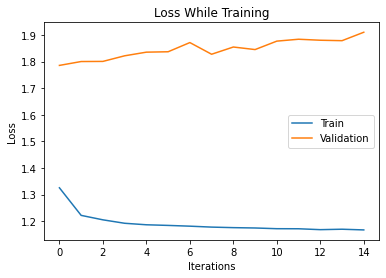

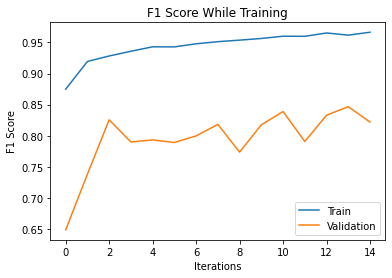

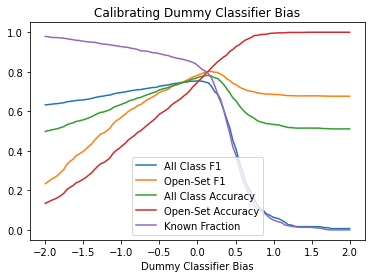

Results from test set using 95% bias (-1.3939):
0.6729624762386947
All Class F1: 0.6730
0.4345628159520689
Open-Set F1: 0.4346
tf.Tensor(0.5759375, shape=(), dtype=float32)
All Class Accuracy: 0.5759
tf.Tensor(0.29150966, shape=(), dtype=float32)
Open-Set Accuracy: 0.2915
Epoch 1/35
781/781 [==============================] - 7s 8ms/step - f1: 0.7960 - loss: 1.5528 - val_loss: 0.0000e+00 - val_f1: 0.7371
Epoch 2/35
781/781 [==============================] - 6s 8ms/step - f1: 0.8521 - loss: 1.2676 - val_loss: 0.0000e+00 - val_f1: 0.7338
Epoch 3/35
781/781 [==============================] - 6s 8ms/step - f1: 0.8649 - loss: 1.2619 - val_loss: 0.0000e+00 - val_f1: 0.6383
Epoch 4/35
781/781 [==============================] - 6s 8ms/step - f1: 0.8693 - loss: 1.2443 - val_loss: 0.0000e+00 - val_f1: 0.5914
Epoch 5/35
781/781 [==============================] - 6s 8ms/step - f1: 0.8755 - loss: 1.3036 - val_loss: 0.0000e+00 - val_f1: 0.7554
Epoch 6/35
781/781 [==============================] - 6s 

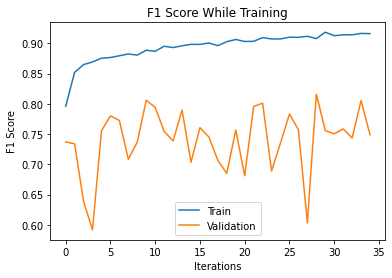

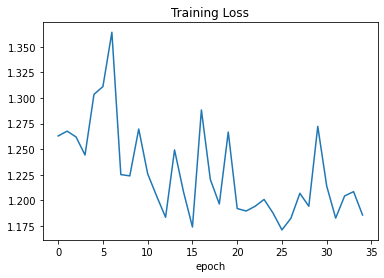

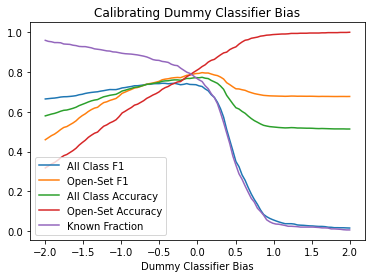

Results from test set using 95% bias (-1.8788):
0.6817361113988173
All Class F1: 0.6817
0.4961487383798141
Open-Set F1: 0.4961
tf.Tensor(0.6025625, shape=(), dtype=float32)
All Class Accuracy: 0.6026
tf.Tensor(0.35192162, shape=(), dtype=float32)
Open-Set Accuracy: 0.3519


In [ ]:
metric_train_OSPLRM_placeholder = {"All Class F1":[], "Open-Set F1":[], "All Class Accuracy":[], "Open-Set Accuracy":[]}
metric_train_OSPWDPLSM_placeholder = {"All Class F1":[], "Open-Set F1":[], "All Class Accuracy":[], "Open-Set Accuracy":[]}


for placeholder_val in [1, 5, 10, 25, 50 , 100, 250]:

  print("--------------------------------------")
  print("######################################")
  print('-------------PLACEHOLDER VALUE {} ---------------'.format(placeholder_val))
  print("######################################")
  print("--------------------------------------")
  model = train_OSPLRM(
      X, y,
      num_classes=NUM_CLASSES,
      epochs=15,
      num_placeholders=placeholder_val,
      pre_dim=300,
      post_dim=300,
      beta=.7,
      plot=True,
  )

  bias = tune_OSPLRM_threshold(model, X_val, y_val)
  model.bias = bias

  y_test_open = modify_open_set_labels(y_test, OPEN_SET_LABELS)

  y_pred = model.predict(X_test)
  print('Results from test set using 95% bias ({:.4f}):'.format(bias))
  for metric in tuning_metrics:
      metric_func = tuning_metrics[metric]
      valueOfMetric = metric_func(y_test_open, y_pred)
      print(valueOfMetric)
      metric_train_OSPLRM_placeholder[metric].append(valueOfMetric)
      print('{}: {:.4f}'.format(metric, valueOfMetric))



  # ----------------------------------- #



  model = train_OSPWDPLSM(
      X, y,
      num_classes=NUM_CLASSES,
      epochs=35,
      num_placeholders=placeholder_val,
      pre_dim=100,
      post_dim=100,
      alpha=2.0,
      beta=.7,
      gamma=.2,
      plot=True,
  )


  bias = tune_OSPLRM_threshold(model, X_val, y_val, OPEN_SET_LABELS)
  model.bias = bias
  y_test_open = modify_open_set_labels(y_test, OPEN_SET_LABELS)

  y_pred = model.predict(X_test)
  print('Results from test set using 95% bias ({:.4f}):'.format(bias))
  for metric in tuning_metrics:
      metric_func = tuning_metrics[metric]
      valueOfMetric = metric_func(y_test_open, y_pred)
      print(valueOfMetric)
      metric_train_OSPWDPLSM_placeholder[metric].append(valueOfMetric)
      print('{}: {:.4f}'.format(metric, valueOfMetric))




In [ ]:
print(metric_train_OSPLRM_placeholder)
print(metric_train_OSPWDPLSM_placeholder)
print("\n----------------------------\n")
headers = [1, 5, 10, 25, 50 , 100, 250]
print(f'{"Score Type": <20}{headers[0]: <20}{headers[1]: <20}{headers[2]: <20}{headers[3]: <20}{headers[4]: <20}{headers[5]: <20}{headers[6]: <20}')
for key, value in metric_train_OSPLRM_placeholder.items():
    print(f'{key: <20}{value[0]: <20}{value[1]: <20}{value[2]: <20}{value[3]: <20}{value[4]: <20}{value[5]: <20}{value[6]: <20}')

print("\n\n")
print(f'{"Score Type": <20}{headers[0]: <20}{headers[1]: <20}{headers[2]: <20}{headers[3]: <20}{headers[4]: <20}{headers[5]: <20}{headers[6]: <20}')
for key, value in metric_train_OSPWDPLSM_placeholder.items():
    print(f'{key: <20}{value[0]: <20}{value[1]: <20}{value[2]: <20}{value[3]: <20}{value[4]: <20}{value[5]: <20}{value[6]: <20}')


{'All Class F1': [0.6739395141555014, 0.6797541689401274, 0.6732889598129842, 0.6676506054563041, 0.6834690942905697, 0.6831482811812081, 0.6729624762386947], 'Open-Set F1': [0.42721011416171334, 0.463347921225383, 0.4287185247589629, 0.39630271519352983, 0.47550928021729283, 0.47694406548431106, 0.4345628159520689], 'All Class Accuracy': [<tf.Tensor: shape=(), dtype=float32, numpy=0.5725>, <tf.Tensor: shape=(), dtype=float32, numpy=0.5885>, <tf.Tensor: shape=(), dtype=float32, numpy=0.5719375>, <tf.Tensor: shape=(), dtype=float32, numpy=0.5598125>, <tf.Tensor: shape=(), dtype=float32, numpy=0.593>, <tf.Tensor: shape=(), dtype=float32, numpy=0.594625>, <tf.Tensor: shape=(), dtype=float32, numpy=0.5759375>], 'Open-Set Accuracy': [<tf.Tensor: shape=(), dtype=float32, numpy=0.28435066>, <tf.Tensor: shape=(), dtype=float32, numpy=0.3191409>, <tf.Tensor: shape=(), dtype=float32, numpy=0.28761616>, <tf.Tensor: shape=(), dtype=float32, numpy=0.25847778>, <tf.Tensor: shape=(), dtype=float32, n

--------------------------------------
######################################
-------------alpha VALUE 0.5 ---------------
######################################
--------------------------------------
Epoch 1/15
1563/1563 [==============================] - 7s 4ms/step - loss: 1.3275 - f1: 0.8734 - val_loss: 1.8139 - val_f1: 0.7111
Epoch 2/15
1563/1563 [==============================] - 7s 4ms/step - loss: 1.2248 - f1: 0.9148 - val_loss: 1.8299 - val_f1: 0.7646
Epoch 3/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2058 - f1: 0.9271 - val_loss: 1.8198 - val_f1: 0.8044
Epoch 4/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.1946 - f1: 0.9340 - val_loss: 1.8398 - val_f1: 0.7908
Epoch 5/15
1563/1563 [==============================] - 7s 4ms/step - loss: 1.1853 - f1: 0.9431 - val_loss: 1.8352 - val_f1: 0.8098
Epoch 6/15
1563/1563 [==============================] - 7s 4ms/step - loss: 1.1843 - f1: 0.9422 - val_loss: 1.8943 - val_f1: 0.7535
Epoch 7

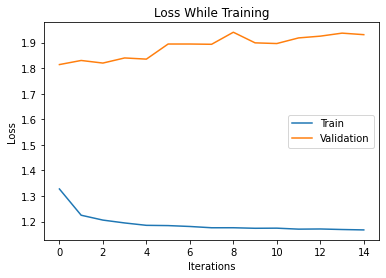

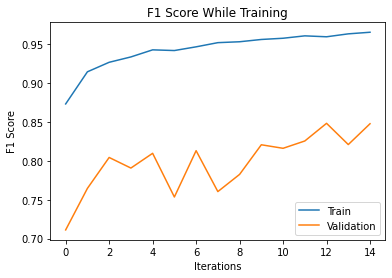

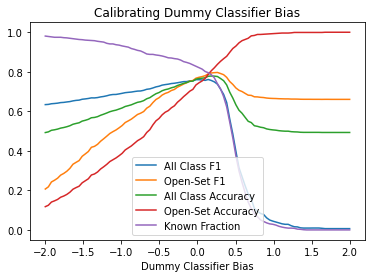

Results from test set using 95% bias (-1.2323):
0.6819674626336859
All Class F1: 0.6820
0.48265973653553185
Open-Set F1: 0.4827
tf.Tensor(0.59625, shape=(), dtype=float32)
All Class Accuracy: 0.5962
tf.Tensor(0.3367934, shape=(), dtype=float32)
Open-Set Accuracy: 0.3368
Epoch 1/35
781/781 [==============================] - 6s 7ms/step - f1: 0.7552 - loss: 1.6292 - val_loss: 0.0000e+00 - val_f1: 0.6236
Epoch 2/35
781/781 [==============================] - 5s 7ms/step - f1: 0.8206 - loss: 1.4249 - val_loss: 0.0000e+00 - val_f1: 0.5504
Epoch 3/35
781/781 [==============================] - 6s 7ms/step - f1: 0.8168 - loss: 1.1968 - val_loss: 0.0000e+00 - val_f1: 0.6741
Epoch 4/35
781/781 [==============================] - 5s 7ms/step - f1: 0.8290 - loss: 1.2590 - val_loss: 0.0000e+00 - val_f1: 0.7188
Epoch 5/35
781/781 [==============================] - 5s 7ms/step - f1: 0.8302 - loss: 1.2963 - val_loss: 0.0000e+00 - val_f1: 0.6285
Epoch 6/35
781/781 [==============================] - 5s 7m

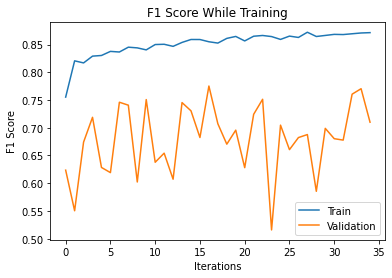

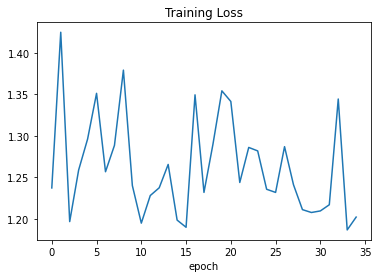

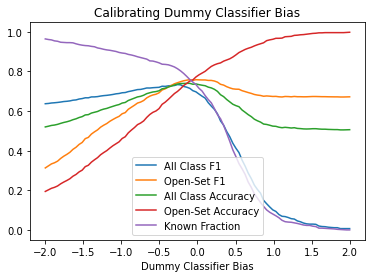

Results from test set using 95% bias (-1.8384):
0.6630297264706216
All Class F1: 0.6630
0.38364110992942085
Open-Set F1: 0.3836
tf.Tensor(0.55425, shape=(), dtype=float32)
All Class Accuracy: 0.5543
tf.Tensor(0.24812406, shape=(), dtype=float32)
Open-Set Accuracy: 0.2481
--------------------------------------
######################################
-------------alpha VALUE 1.0 ---------------
######################################
--------------------------------------
Epoch 1/15
1563/1563 [==============================] - 8s 4ms/step - loss: 1.3284 - f1: 0.8722 - val_loss: 1.7972 - val_f1: 0.7508
Epoch 2/15
1563/1563 [==============================] - 7s 4ms/step - loss: 1.2235 - f1: 0.9173 - val_loss: 1.8058 - val_f1: 0.7770
Epoch 3/15
1563/1563 [==============================] - 7s 4ms/step - loss: 1.2044 - f1: 0.9283 - val_loss: 1.8481 - val_f1: 0.7887
Epoch 4/15
1563/1563 [==============================] - 7s 4ms/step - loss: 1.1958 - f1: 0.9357 - val_loss: 1.8508 - val_f1: 0.8229

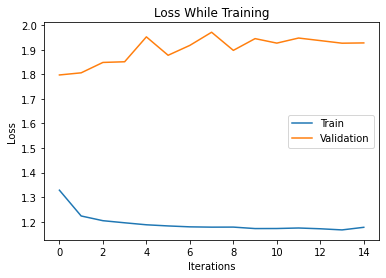

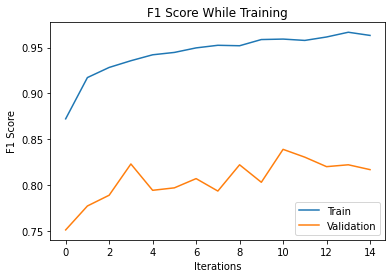

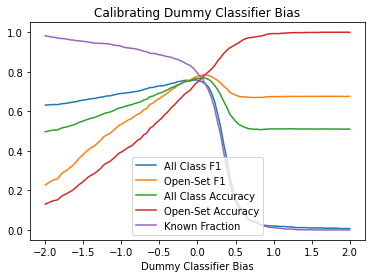

Results from test set using 95% bias (-1.4343):
0.6717474207719205
All Class F1: 0.6717
0.39850488786659
Open-Set F1: 0.3985
tf.Tensor(0.5605, shape=(), dtype=float32)
All Class Accuracy: 0.5605
tf.Tensor(0.260005, shape=(), dtype=float32)
Open-Set Accuracy: 0.2600
Epoch 1/35
781/781 [==============================] - 6s 7ms/step - f1: 0.7722 - loss: 1.6120 - val_loss: 0.0000e+00 - val_f1: 0.7150
Epoch 2/35
781/781 [==============================] - 5s 7ms/step - f1: 0.8366 - loss: 1.2800 - val_loss: 0.0000e+00 - val_f1: 0.6876
Epoch 3/35
781/781 [==============================] - 5s 7ms/step - f1: 0.8423 - loss: 1.4041 - val_loss: 0.0000e+00 - val_f1: 0.7378
Epoch 4/35
781/781 [==============================] - 6s 7ms/step - f1: 0.8507 - loss: 1.2447 - val_loss: 0.0000e+00 - val_f1: 0.7158
Epoch 5/35
781/781 [==============================] - 5s 7ms/step - f1: 0.8548 - loss: 1.3030 - val_loss: 0.0000e+00 - val_f1: 0.6294
Epoch 6/35
781/781 [==============================] - 5s 7ms/ste

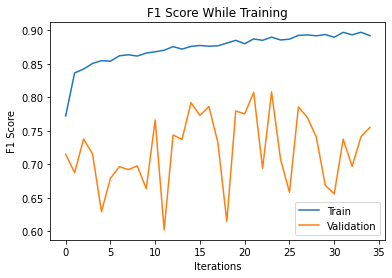

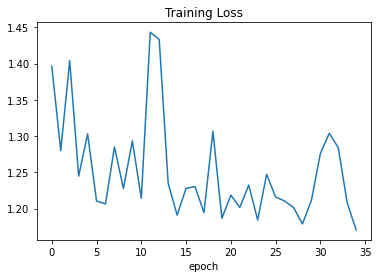

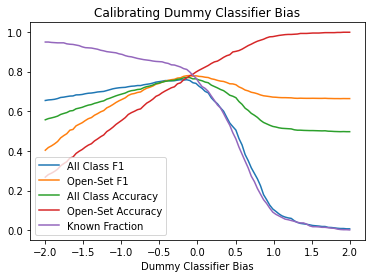

Results from test set using 95% bias (-2.0000):
0.6693155021559011
All Class F1: 0.6693
0.429269209092617
Open-Set F1: 0.4293
tf.Tensor(0.5733125, shape=(), dtype=float32)
All Class Accuracy: 0.5733
tf.Tensor(0.28576788, shape=(), dtype=float32)
Open-Set Accuracy: 0.2858
--------------------------------------
######################################
-------------alpha VALUE 2.0 ---------------
######################################
--------------------------------------
Epoch 1/15
1563/1563 [==============================] - 8s 5ms/step - loss: 1.3276 - f1: 0.8754 - val_loss: 1.8012 - val_f1: 0.7119
Epoch 2/15
1563/1563 [==============================] - 7s 4ms/step - loss: 1.2240 - f1: 0.9177 - val_loss: 1.7821 - val_f1: 0.7648
Epoch 3/15
1563/1563 [==============================] - 7s 4ms/step - loss: 1.2056 - f1: 0.9264 - val_loss: 1.8311 - val_f1: 0.7555
Epoch 4/15
1563/1563 [==============================] - 7s 4ms/step - loss: 1.1930 - f1: 0.9361 - val_loss: 1.8711 - val_f1: 0.8214

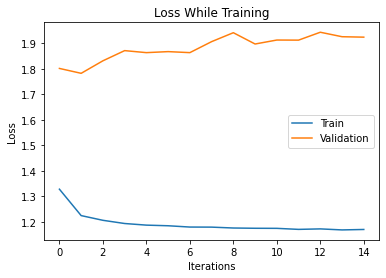

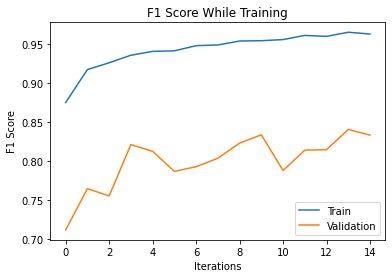

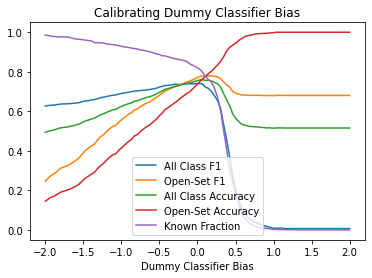

Results from test set using 95% bias (-1.3535):
0.6728085067280615
All Class F1: 0.6728
0.43917410714285715
Open-Set F1: 0.4392
tf.Tensor(0.57675, shape=(), dtype=float32)
All Class Accuracy: 0.5767
tf.Tensor(0.29527265, shape=(), dtype=float32)
Open-Set Accuracy: 0.2953
Epoch 1/35
781/781 [==============================] - 7s 7ms/step - f1: 0.7882 - loss: 1.5904 - val_loss: 0.0000e+00 - val_f1: 0.7459
Epoch 2/35
781/781 [==============================] - 5s 7ms/step - f1: 0.8506 - loss: 1.2446 - val_loss: 0.0000e+00 - val_f1: 0.6916
Epoch 3/35
781/781 [==============================] - 5s 7ms/step - f1: 0.8601 - loss: 1.2491 - val_loss: 0.0000e+00 - val_f1: 0.7148
Epoch 4/35
781/781 [==============================] - 5s 7ms/step - f1: 0.8667 - loss: 1.2309 - val_loss: 0.0000e+00 - val_f1: 0.7032
Epoch 5/35
781/781 [==============================] - 5s 7ms/step - f1: 0.8690 - loss: 1.2451 - val_loss: 0.0000e+00 - val_f1: 0.7684
Epoch 6/35
781/781 [==============================] - 5s 7

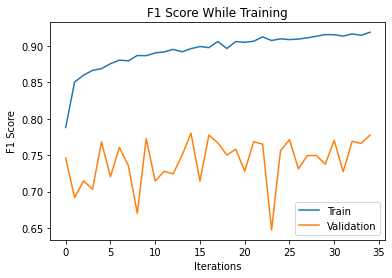

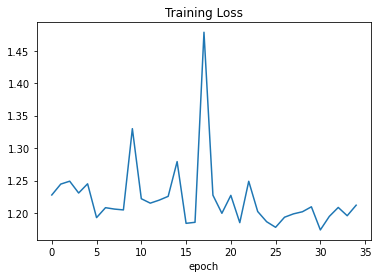

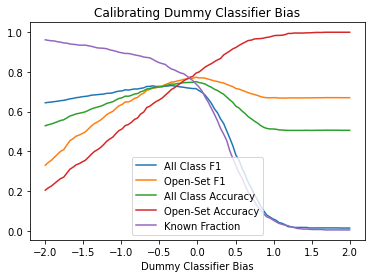

Results from test set using 95% bias (-1.7980):
0.6690816703531564
All Class F1: 0.6691
0.4159224776743302
Open-Set F1: 0.4159
tf.Tensor(0.5660625, shape=(), dtype=float32)
All Class Accuracy: 0.5661
tf.Tensor(0.27376187, shape=(), dtype=float32)
Open-Set Accuracy: 0.2738
--------------------------------------
######################################
-------------alpha VALUE 5.0 ---------------
######################################
--------------------------------------
Epoch 1/15
1563/1563 [==============================] - 8s 5ms/step - loss: 1.3256 - f1: 0.8736 - val_loss: 1.8326 - val_f1: 0.7359
Epoch 2/15
1563/1563 [==============================] - 7s 4ms/step - loss: 1.2239 - f1: 0.9181 - val_loss: 1.8290 - val_f1: 0.7779
Epoch 3/15
1563/1563 [==============================] - 7s 5ms/step - loss: 1.2047 - f1: 0.9288 - val_loss: 1.8721 - val_f1: 0.7809
Epoch 4/15
1563/1563 [==============================] - 7s 5ms/step - loss: 1.1945 - f1: 0.9363 - val_loss: 1.8860 - val_f1: 0.813

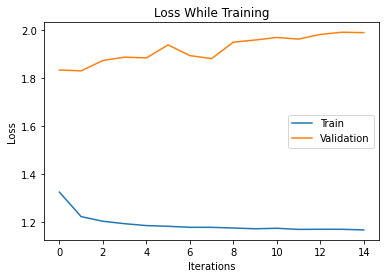

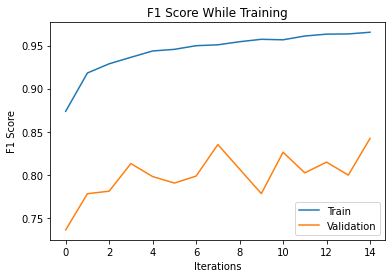

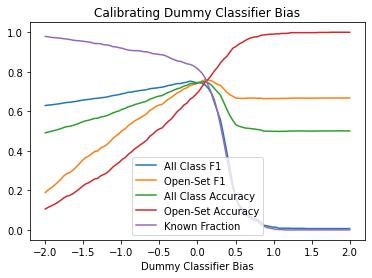

Results from test set using 95% bias (-1.4343):
0.6556539722487129
All Class F1: 0.6557
0.3449851042701092
Open-Set F1: 0.3450
tf.Tensor(0.5385, shape=(), dtype=float32)
All Class Accuracy: 0.5385
tf.Tensor(0.21723361, shape=(), dtype=float32)
Open-Set Accuracy: 0.2172
Epoch 1/35
781/781 [==============================] - 7s 8ms/step - f1: 0.8007 - loss: 1.5662 - val_loss: 0.0000e+00 - val_f1: 0.7009
Epoch 2/35
781/781 [==============================] - 6s 7ms/step - f1: 0.8635 - loss: 1.3026 - val_loss: 0.0000e+00 - val_f1: 0.6971
Epoch 3/35
781/781 [==============================] - 6s 7ms/step - f1: 0.8750 - loss: 1.2278 - val_loss: 0.0000e+00 - val_f1: 0.6764
Epoch 4/35
781/781 [==============================] - 6s 7ms/step - f1: 0.8850 - loss: 1.4630 - val_loss: 0.0000e+00 - val_f1: 0.6444
Epoch 5/35
781/781 [==============================] - 6s 7ms/step - f1: 0.8857 - loss: 1.2395 - val_loss: 0.0000e+00 - val_f1: 0.6013
Epoch 6/35
781/781 [==============================] - 6s 7ms

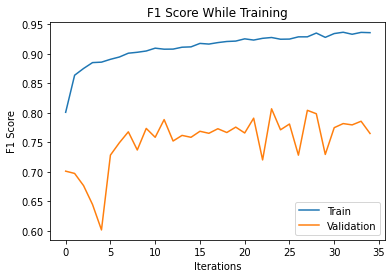

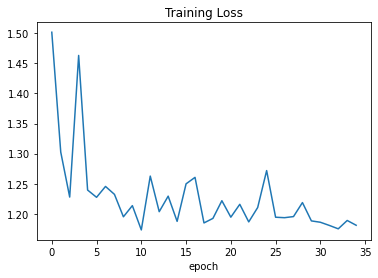

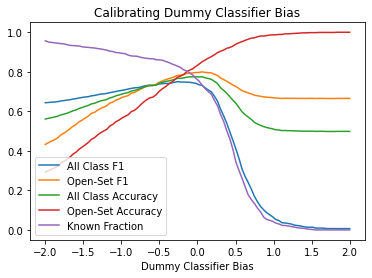

Results from test set using 95% bias (-1.9596):
0.6703997962047941
All Class F1: 0.6704
0.4427805509336291
Open-Set F1: 0.4428
tf.Tensor(0.577625, shape=(), dtype=float32)
All Class Accuracy: 0.5776
tf.Tensor(0.29952475, shape=(), dtype=float32)
Open-Set Accuracy: 0.2995


In [ ]:
metric_train_OSPLRM_abga = {"All Class F1":[], "Open-Set F1":[], "All Class Accuracy":[], "Open-Set Accuracy":[]}
metric_train_OSPWDPLSM_abga = {"All Class F1":[], "Open-Set F1":[], "All Class Accuracy":[], "Open-Set Accuracy":[]}
heading_abg_val = []
beta_val = .7
gamma_val = .2

for alpha_val in [.5,1.0,2.0,5.0]:
      print("--------------------------------------")
      print("######################################")
      print('-------------alpha VALUE {} ---------------'.format(alpha_val))
      print("######################################")
      print("--------------------------------------")
      model = train_OSPLRM(
          X, y,
          num_classes=NUM_CLASSES,
          epochs=15,
          num_placeholders=50,
          pre_dim=300,
          post_dim=300,
          beta=beta_val,
          plot=True,
      )

      bias = tune_OSPLRM_threshold(model, X_val, y_val)
      model.bias = bias
      y_test_open = modify_open_set_labels(y_test, OPEN_SET_LABELS)

      y_pred = model.predict(X_test)
      print('Results from test set using 95% bias ({:.4f}):'.format(bias))
      for metric in tuning_metrics:
          metric_func = tuning_metrics[metric]
          valueOfMetric = metric_func(y_test_open, y_pred)
          print(valueOfMetric)
          metric_train_OSPLRM_abga[metric].append(valueOfMetric)
          print('{}: {:.4f}'.format(metric, valueOfMetric))



      # ----------------------------------- #



      model = train_OSPWDPLSM(
          X, y,
          num_classes=NUM_CLASSES,
          epochs=35,
          num_placeholders=5,
          pre_dim=100,
          post_dim=100,
          alpha=alpha_val,
          beta=beta_val,
          gamma=gamma_val,
          plot=True,
      )


      bias = tune_OSPLRM_threshold(model, X_val, y_val, OPEN_SET_LABELS)
      model.bias = bias

      y_test_open = modify_open_set_labels(y_test, OPEN_SET_LABELS)

      y_pred = model.predict(X_test)
      print('Results from test set using 95% bias ({:.4f}):'.format(bias))
      for metric in tuning_metrics:
          metric_func = tuning_metrics[metric]
          valueOfMetric = metric_func(y_test_open, y_pred)
          print(valueOfMetric)
          metric_train_OSPWDPLSM_abga[metric].append(valueOfMetric)
          print('{}: {:.4f}'.format(metric, valueOfMetric))




In [ ]:
print(metric_train_OSPLRM_abga)
print(metric_train_OSPWDPLSM_abga)
print("\n----------------------------\n")
headers = [.5,1,2,5]
print(f'{"Score Type": <20}{headers[0]: <20}{headers[1]: <20}{headers[2]: <20}{headers[3]: <20}')
for key, value in metric_train_OSPLRM_abga.items():
    print(f'{key: <20}{value[0]: <20}{value[1]: <20}{value[2]: <20}{value[3]: <20}')

print("\n\n")
print(f'{"Score Type": <20}{headers[0]: <20}{headers[1]: <20}{headers[2]: <20}{headers[3]: <20}')
for key, value in metric_train_OSPWDPLSM_abga.items():
    print(f'{key: <20}{value[0]: <20}{value[1]: <20}{value[2]: <20}{value[3]: <20}')


{'All Class F1': [0.6819674626336859, 0.6717474207719205, 0.6728085067280615, 0.6556539722487129], 'Open-Set F1': [0.48265973653553185, 0.39850488786659, 0.43917410714285715, 0.3449851042701092], 'All Class Accuracy': [<tf.Tensor: shape=(), dtype=float32, numpy=0.59625>, <tf.Tensor: shape=(), dtype=float32, numpy=0.5605>, <tf.Tensor: shape=(), dtype=float32, numpy=0.57675>, <tf.Tensor: shape=(), dtype=float32, numpy=0.5385>], 'Open-Set Accuracy': [<tf.Tensor: shape=(), dtype=float32, numpy=0.3367934>, <tf.Tensor: shape=(), dtype=float32, numpy=0.260005>, <tf.Tensor: shape=(), dtype=float32, numpy=0.29527265>, <tf.Tensor: shape=(), dtype=float32, numpy=0.21723361>]}
{'All Class F1': [0.6630297264706216, 0.6693155021559011, 0.6690816703531564, 0.6703997962047941], 'Open-Set F1': [0.38364110992942085, 0.429269209092617, 0.4159224776743302, 0.4427805509336291], 'All Class Accuracy': [<tf.Tensor: shape=(), dtype=float32, numpy=0.55425>, <tf.Tensor: shape=(), dtype=float32, numpy=0.5733125>,

--------------------------------------
######################################
-------------beta VALUE 0.1 ---------------
######################################
--------------------------------------
Epoch 1/15
1563/1563 [==============================] - 7s 4ms/step - loss: 0.4680 - f1: 0.9719 - val_loss: 1.0271 - val_f1: 0.8545
Epoch 2/15
1563/1563 [==============================] - 7s 4ms/step - loss: 0.3896 - f1: 0.9807 - val_loss: 1.0720 - val_f1: 0.8545
Epoch 3/15
1563/1563 [==============================] - 7s 4ms/step - loss: 0.3765 - f1: 0.9833 - val_loss: 1.0990 - val_f1: 0.8626
Epoch 4/15
1563/1563 [==============================] - 6s 4ms/step - loss: 0.3671 - f1: 0.9847 - val_loss: 1.1595 - val_f1: 0.8523
Epoch 5/15
1563/1563 [==============================] - 7s 4ms/step - loss: 0.3591 - f1: 0.9865 - val_loss: 1.1088 - val_f1: 0.8629
Epoch 6/15
1563/1563 [==============================] - 6s 4ms/step - loss: 0.3601 - f1: 0.9866 - val_loss: 1.2246 - val_f1: 0.8498
Epoch 7/

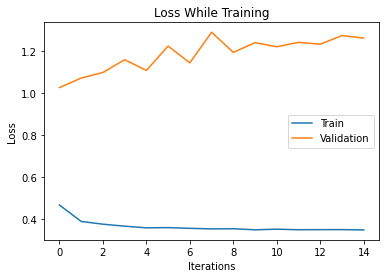

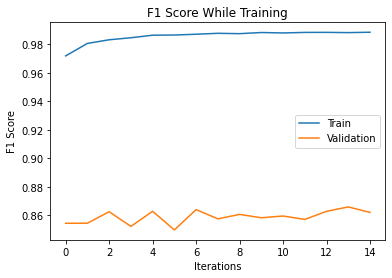

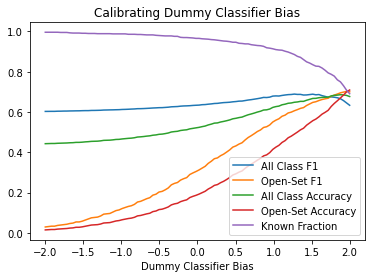

Results from test set using 95% bias (0.4242):
0.6684259940441338
All Class F1: 0.6684
0.42445234974723833
Open-Set F1: 0.4245
tf.Tensor(0.5695625, shape=(), dtype=float32)
All Class Accuracy: 0.5696
tf.Tensor(0.28351676, shape=(), dtype=float32)
Open-Set Accuracy: 0.2835
Epoch 1/35
781/781 [==============================] - 6s 7ms/step - f1: 0.9396 - loss: 0.8128 - val_loss: 0.0000e+00 - val_f1: 0.8344
Epoch 2/35
781/781 [==============================] - 5s 6ms/step - f1: 0.9722 - loss: 0.8696 - val_loss: 0.0000e+00 - val_f1: 0.8508
Epoch 3/35
781/781 [==============================] - 5s 6ms/step - f1: 0.9760 - loss: 0.5745 - val_loss: 0.0000e+00 - val_f1: 0.8484
Epoch 4/35
781/781 [==============================] - 5s 6ms/step - f1: 0.9770 - loss: 0.7393 - val_loss: 0.0000e+00 - val_f1: 0.8473
Epoch 5/35
781/781 [==============================] - 5s 7ms/step - f1: 0.9778 - loss: 0.4692 - val_loss: 0.0000e+00 - val_f1: 0.8515
Epoch 6/35
781/781 [==============================] - 5s 

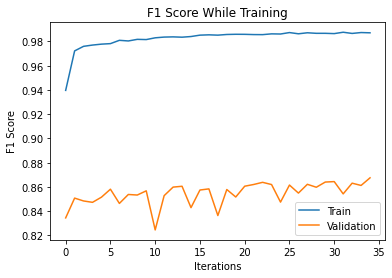

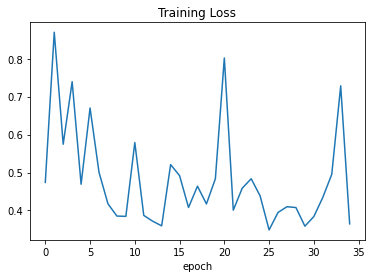

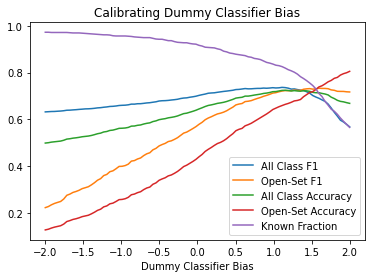

Results from test set using 95% bias (-0.7071):
0.6674302083553835
All Class F1: 0.6674
0.4388837209302326
Open-Set F1: 0.4389
tf.Tensor(0.576, shape=(), dtype=float32)
All Class Accuracy: 0.5760
tf.Tensor(0.29502252, shape=(), dtype=float32)
Open-Set Accuracy: 0.2950
--------------------------------------
######################################
-------------beta VALUE 0.25 ---------------
######################################
--------------------------------------
Epoch 1/15
1563/1563 [==============================] - 7s 4ms/step - loss: 0.7738 - f1: 0.9664 - val_loss: 1.2813 - val_f1: 0.8625
Epoch 2/15
1563/1563 [==============================] - 6s 4ms/step - loss: 0.6867 - f1: 0.9792 - val_loss: 1.3178 - val_f1: 0.8560
Epoch 3/15
1563/1563 [==============================] - 6s 4ms/step - loss: 0.6704 - f1: 0.9818 - val_loss: 1.3476 - val_f1: 0.8551
Epoch 4/15
1563/1563 [==============================] - 7s 4ms/step - loss: 0.6599 - f1: 0.9839 - val_loss: 1.3691 - val_f1: 0.8646
Ep

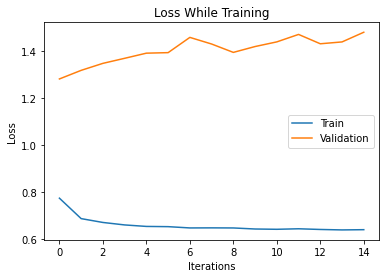

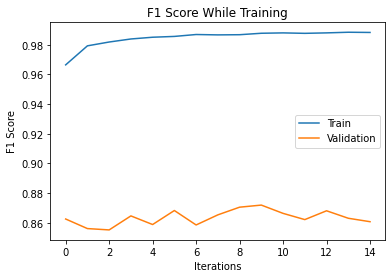

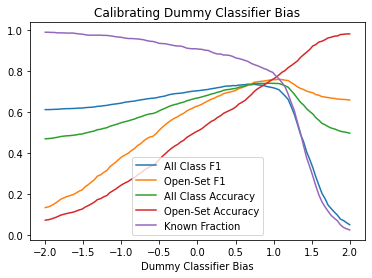

Results from test set using 95% bias (-0.6667):
0.6725542730635358
All Class F1: 0.6726
0.44423791821561337
Open-Set F1: 0.4442
tf.Tensor(0.578625, shape=(), dtype=float32)
All Class Accuracy: 0.5786
tf.Tensor(0.29889944, shape=(), dtype=float32)
Open-Set Accuracy: 0.2989
Epoch 1/35
781/781 [==============================] - 6s 7ms/step - f1: 0.9171 - loss: 1.1064 - val_loss: 0.0000e+00 - val_f1: 0.8089
Epoch 2/35
781/781 [==============================] - 5s 7ms/step - f1: 0.9616 - loss: 0.6719 - val_loss: 0.0000e+00 - val_f1: 0.8310
Epoch 3/35
781/781 [==============================] - 5s 7ms/step - f1: 0.9683 - loss: 0.7572 - val_loss: 0.0000e+00 - val_f1: 0.8270
Epoch 4/35
781/781 [==============================] - 5s 7ms/step - f1: 0.9708 - loss: 0.6884 - val_loss: 0.0000e+00 - val_f1: 0.8412
Epoch 5/35
781/781 [==============================] - 5s 7ms/step - f1: 0.9707 - loss: 0.7138 - val_loss: 0.0000e+00 - val_f1: 0.8533
Epoch 6/35
781/781 [==============================] - 5s 

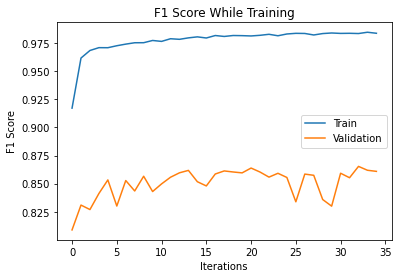

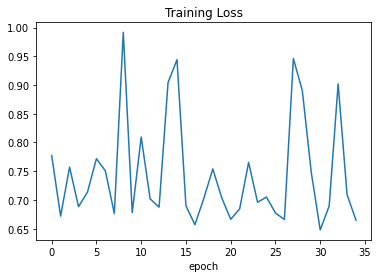

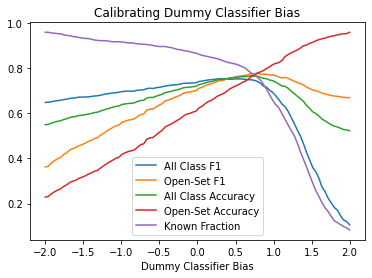

Results from test set using 95% bias (-1.7576):
0.6629954238685719
All Class F1: 0.6630
0.4048706240487062
Open-Set F1: 0.4049
tf.Tensor(0.5619375, shape=(), dtype=float32)
All Class Accuracy: 0.5619
tf.Tensor(0.26613307, shape=(), dtype=float32)
Open-Set Accuracy: 0.2661
--------------------------------------
######################################
-------------beta VALUE 0.5 ---------------
######################################
--------------------------------------
Epoch 1/15
1563/1563 [==============================] - 8s 4ms/step - loss: 1.1176 - f1: 0.9368 - val_loss: 1.6561 - val_f1: 0.8143
Epoch 2/15
1563/1563 [==============================] - 7s 4ms/step - loss: 1.0236 - f1: 0.9625 - val_loss: 1.6194 - val_f1: 0.8494
Epoch 3/15
1563/1563 [==============================] - 7s 4ms/step - loss: 1.0053 - f1: 0.9692 - val_loss: 1.6705 - val_f1: 0.8303
Epoch 4/15
1563/1563 [==============================] - 7s 4ms/step - loss: 0.9931 - f1: 0.9731 - val_loss: 1.6872 - val_f1: 0.8491

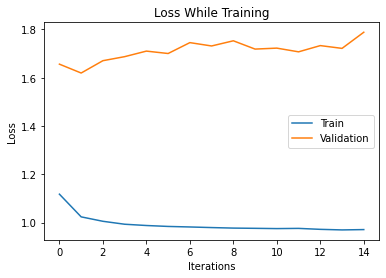

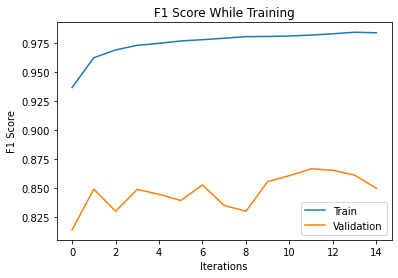

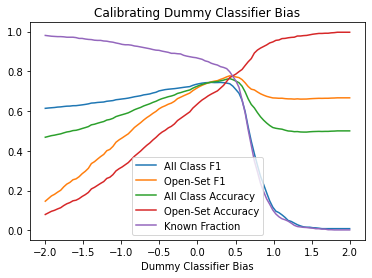

Results from test set using 95% bias (-1.1515):
0.6694664226980522
All Class F1: 0.6695
0.4212818328126479
Open-Set F1: 0.4213
tf.Tensor(0.57, shape=(), dtype=float32)
All Class Accuracy: 0.5700
tf.Tensor(0.27826414, shape=(), dtype=float32)
Open-Set Accuracy: 0.2783
Epoch 1/35
781/781 [==============================] - 7s 7ms/step - f1: 0.8641 - loss: 1.3981 - val_loss: 0.0000e+00 - val_f1: 0.7389
Epoch 2/35
781/781 [==============================] - 5s 7ms/step - f1: 0.9201 - loss: 1.2424 - val_loss: 0.0000e+00 - val_f1: 0.7744
Epoch 3/35
781/781 [==============================] - 5s 7ms/step - f1: 0.9233 - loss: 1.0078 - val_loss: 0.0000e+00 - val_f1: 0.7547
Epoch 4/35
781/781 [==============================] - 5s 7ms/step - f1: 0.9311 - loss: 1.0908 - val_loss: 0.0000e+00 - val_f1: 0.7657
Epoch 5/35
781/781 [==============================] - 5s 7ms/step - f1: 0.9308 - loss: 1.0762 - val_loss: 0.0000e+00 - val_f1: 0.8134
Epoch 6/35
781/781 [==============================] - 6s 7ms/s

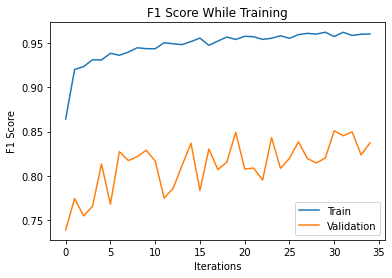

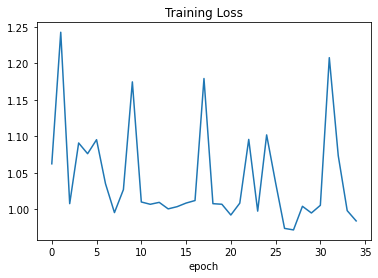

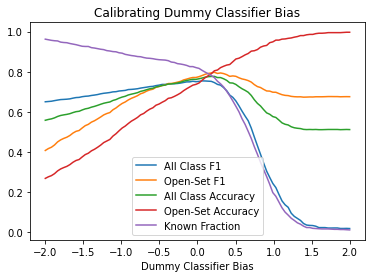

Results from test set using 95% bias (-1.7980):
0.6751739230940559
All Class F1: 0.6752
0.464628023733455
Open-Set F1: 0.4646
tf.Tensor(0.5885, shape=(), dtype=float32)
All Class Accuracy: 0.5885
tf.Tensor(0.31828415, shape=(), dtype=float32)
Open-Set Accuracy: 0.3183
--------------------------------------
######################################
-------------beta VALUE 0.75 ---------------
######################################
--------------------------------------
Epoch 1/15
1563/1563 [==============================] - 8s 5ms/step - loss: 1.3735 - f1: 0.8492 - val_loss: 1.8722 - val_f1: 0.7094
Epoch 2/15
1563/1563 [==============================] - 7s 4ms/step - loss: 1.2677 - f1: 0.8955 - val_loss: 1.8663 - val_f1: 0.7253
Epoch 3/15
1563/1563 [==============================] - 7s 5ms/step - loss: 1.2492 - f1: 0.9056 - val_loss: 1.9147 - val_f1: 0.7607
Epoch 4/15
1563/1563 [==============================] - 7s 5ms/step - loss: 1.2380 - f1: 0.9151 - val_loss: 1.9681 - val_f1: 0.7860
Ep

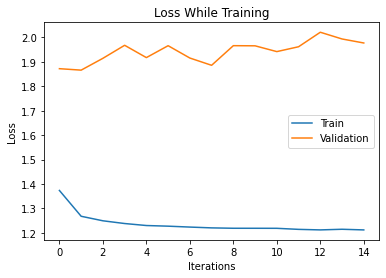

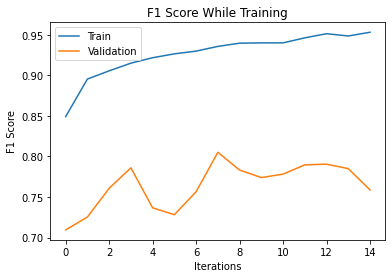

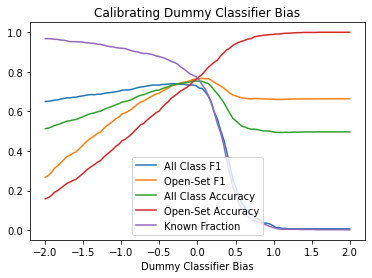

Results from test set using 95% bias (-1.5152):
0.6773260247779546
All Class F1: 0.6773
0.4465839659322348
Open-Set F1: 0.4466
tf.Tensor(0.58125, shape=(), dtype=float32)
All Class Accuracy: 0.5813
tf.Tensor(0.30165082, shape=(), dtype=float32)
Open-Set Accuracy: 0.3017
Epoch 1/35
781/781 [==============================] - 7s 7ms/step - f1: 0.7442 - loss: 1.6312 - val_loss: 0.0000e+00 - val_f1: 0.6279
Epoch 2/35
781/781 [==============================] - 6s 7ms/step - f1: 0.7951 - loss: 1.5130 - val_loss: 0.0000e+00 - val_f1: 0.5912
Epoch 3/35
781/781 [==============================] - 6s 7ms/step - f1: 0.8108 - loss: 1.3147 - val_loss: 0.0000e+00 - val_f1: 0.7577
Epoch 4/35
781/781 [==============================] - 6s 7ms/step - f1: 0.8151 - loss: 1.3195 - val_loss: 0.0000e+00 - val_f1: 0.6129
Epoch 5/35
781/781 [==============================] - 6s 7ms/step - f1: 0.8178 - loss: 1.3358 - val_loss: 0.0000e+00 - val_f1: 0.4521
Epoch 6/35
781/781 [==============================] - 6s 7m

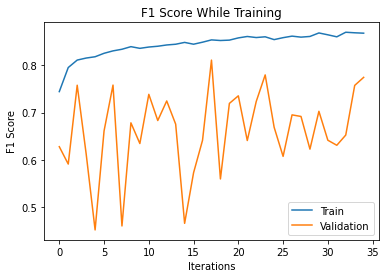

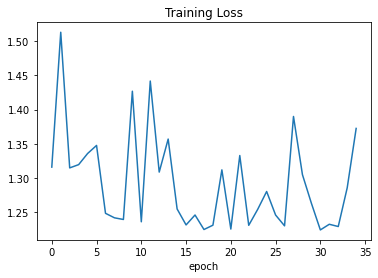

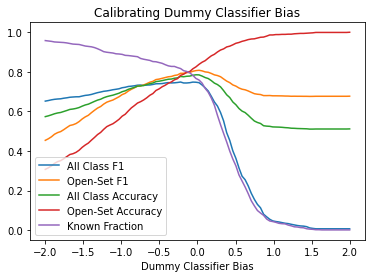

Results from test set using 95% bias (-1.8384):
0.6821638354168762
All Class F1: 0.6822
0.49000713775874377
Open-Set F1: 0.4900
tf.Tensor(0.5996875, shape=(), dtype=float32)
All Class Accuracy: 0.5997
tf.Tensor(0.3434217, shape=(), dtype=float32)
Open-Set Accuracy: 0.3434
--------------------------------------
######################################
-------------beta VALUE 0.9 ---------------
######################################
--------------------------------------
Epoch 1/15
1563/1563 [==============================] - 8s 5ms/step - loss: 1.4992 - f1: 0.7415 - val_loss: 1.9826 - val_f1: 0.6743
Epoch 2/15
1563/1563 [==============================] - 7s 5ms/step - loss: 1.3894 - f1: 0.7786 - val_loss: 1.9947 - val_f1: 0.6174
Epoch 3/15
1563/1563 [==============================] - 7s 5ms/step - loss: 1.3698 - f1: 0.7900 - val_loss: 2.0466 - val_f1: 0.6113
Epoch 4/15
1563/1563 [==============================] - 7s 5ms/step - loss: 1.3587 - f1: 0.7996 - val_loss: 2.0448 - val_f1: 0.6795

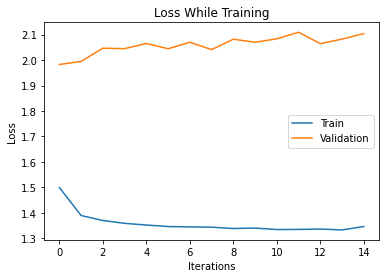

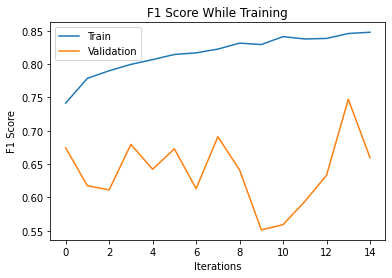

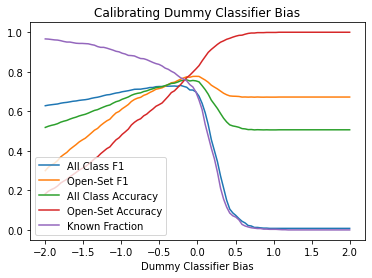

Results from test set using 95% bias (-1.7172):
0.6630629131174114
All Class F1: 0.6631
0.40099626400996263
Open-Set F1: 0.4010
tf.Tensor(0.55875, shape=(), dtype=float32)
All Class Accuracy: 0.5587
tf.Tensor(0.26175588, shape=(), dtype=float32)
Open-Set Accuracy: 0.2618
Epoch 1/35
781/781 [==============================] - 7s 8ms/step - f1: 0.6365 - loss: 1.7639 - val_loss: 0.0000e+00 - val_f1: 0.3951
Epoch 2/35
781/781 [==============================] - 6s 7ms/step - f1: 0.6801 - loss: 1.4519 - val_loss: 0.0000e+00 - val_f1: 0.4261
Epoch 3/35
781/781 [==============================] - 6s 7ms/step - f1: 0.6896 - loss: 1.4528 - val_loss: 0.0000e+00 - val_f1: 0.4125
Epoch 4/35
781/781 [==============================] - 6s 7ms/step - f1: 0.6944 - loss: 1.4238 - val_loss: 0.0000e+00 - val_f1: 0.4417
Epoch 5/35
781/781 [==============================] - 6s 8ms/step - f1: 0.6944 - loss: 1.4474 - val_loss: 0.0000e+00 - val_f1: 0.5822
Epoch 6/35
781/781 [==============================] - 6s 7

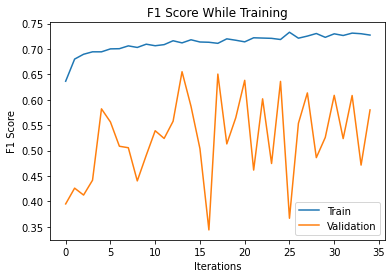

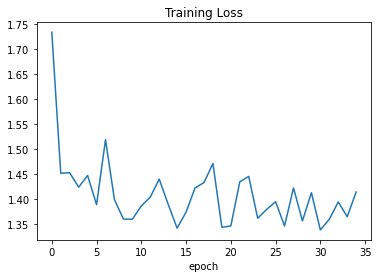

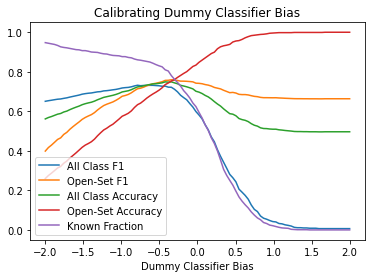

Results from test set using 95% bias (-2.0000):
0.6615735301706224
All Class F1: 0.6616
0.3866679510644447
Open-Set F1: 0.3867
tf.Tensor(0.5561875, shape=(), dtype=float32)
All Class Accuracy: 0.5562
tf.Tensor(0.2510005, shape=(), dtype=float32)
Open-Set Accuracy: 0.2510
--------------------------------------
######################################
-------------beta VALUE 1.0 ---------------
######################################
--------------------------------------
Epoch 1/15
1563/1563 [==============================] - 8s 5ms/step - loss: 1.5783 - f1: 0.6484 - val_loss: 2.0632 - val_f1: 0.4912
Epoch 2/15
1563/1563 [==============================] - 7s 5ms/step - loss: 1.4651 - f1: 0.6589 - val_loss: 2.0816 - val_f1: 0.5985
Epoch 3/15
1563/1563 [==============================] - 7s 5ms/step - loss: 1.4453 - f1: 0.6571 - val_loss: 2.0687 - val_f1: 0.4465
Epoch 4/15
1563/1563 [==============================] - 7s 5ms/step - loss: 1.4322 - f1: 0.6597 - val_loss: 2.0975 - val_f1: 0.4257


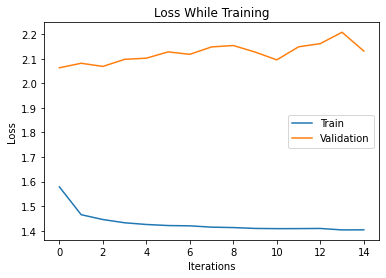

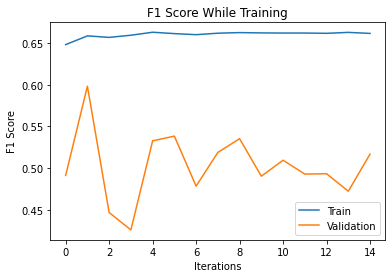

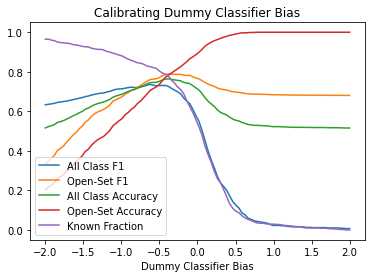

Results from test set using 95% bias (-1.8384):
0.6700997578770224
All Class F1: 0.6701
0.418844173183292
Open-Set F1: 0.4188
tf.Tensor(0.5665, shape=(), dtype=float32)
All Class Accuracy: 0.5665
tf.Tensor(0.2746373, shape=(), dtype=float32)
Open-Set Accuracy: 0.2746
Epoch 1/35
781/781 [==============================] - 7s 8ms/step - f1: 0.5559 - loss: 1.8537 - val_loss: 0.0000e+00 - val_f1: 0.4547
Epoch 2/35
781/781 [==============================] - 6s 8ms/step - f1: 0.5843 - loss: 1.5173 - val_loss: 0.0000e+00 - val_f1: 0.4097
Epoch 3/35
781/781 [==============================] - 6s 8ms/step - f1: 0.5914 - loss: 1.5269 - val_loss: 0.0000e+00 - val_f1: 0.3872
Epoch 4/35
781/781 [==============================] - 6s 8ms/step - f1: 0.5881 - loss: 1.4557 - val_loss: 0.0000e+00 - val_f1: 0.4374
Epoch 5/35
781/781 [==============================] - 6s 8ms/step - f1: 0.5872 - loss: 1.5105 - val_loss: 0.0000e+00 - val_f1: 0.3165
Epoch 6/35
781/781 [==============================] - 6s 7ms/s

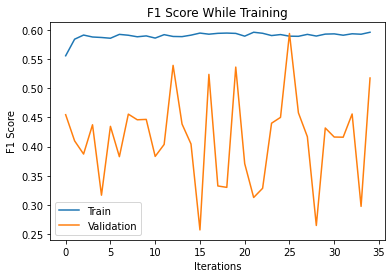

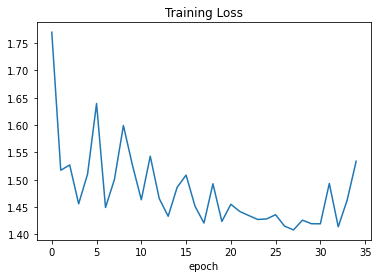

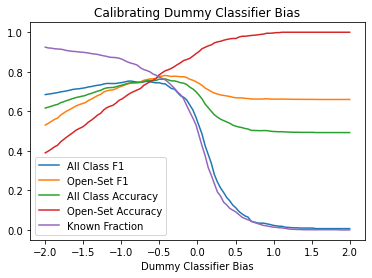

Results from test set using 95% bias (-2.0000):
0.6870727406490277
All Class F1: 0.6871
0.5153096729297146
Open-Set F1: 0.5153
tf.Tensor(0.6111875, shape=(), dtype=float32)
All Class Accuracy: 0.6112
tf.Tensor(0.3704352, shape=(), dtype=float32)
Open-Set Accuracy: 0.3704


In [ ]:
metric_train_OSPLRM_abgb = {"All Class F1":[], "Open-Set F1":[], "All Class Accuracy":[], "Open-Set Accuracy":[]}
metric_train_OSPWDPLSM_abgb = {"All Class F1":[], "Open-Set F1":[], "All Class Accuracy":[], "Open-Set Accuracy":[]}

gamma_val = .2
alpha_val = 1.0
for beta_val in [.1, .25, .5, .75, .9, 1.0]:
      print("--------------------------------------")
      print("######################################")
      print('-------------beta VALUE {} ---------------'.format(beta_val))
      print("######################################")
      print("--------------------------------------")
      model = train_OSPLRM(
          X, y,
          num_classes=NUM_CLASSES,
          epochs=15,
          num_placeholders=50,
          pre_dim=300,
          post_dim=300,
          beta=beta_val,
          plot=True,
      )

      bias = tune_OSPLRM_threshold(model, X_val, y_val)
      model.bias = bias

      y_test_open = modify_open_set_labels(y_test, OPEN_SET_LABELS)

      y_pred = model.predict(X_test)
      print('Results from test set using 95% bias ({:.4f}):'.format(bias))
      for metric in tuning_metrics:
          metric_func = tuning_metrics[metric]
          valueOfMetric = metric_func(y_test_open, y_pred)
          print(valueOfMetric)
          metric_train_OSPLRM_abgb[metric].append(valueOfMetric)
          print('{}: {:.4f}'.format(metric, valueOfMetric))



      # ----------------------------------- #



      model = train_OSPWDPLSM(
          X, y,
          num_classes=NUM_CLASSES,
          epochs=35,
          num_placeholders=5,
          pre_dim=100,
          post_dim=100,
          alpha=alpha_val,
          beta=beta_val,
          gamma=gamma_val,
          plot=True,
      )


      bias = tune_OSPLRM_threshold(model, X_val, y_val, OPEN_SET_LABELS)
      model.bias = bias

      y_test_open = modify_open_set_labels(y_test, OPEN_SET_LABELS)

      y_pred = model.predict(X_test)
      print('Results from test set using 95% bias ({:.4f}):'.format(bias))
      for metric in tuning_metrics:
          metric_func = tuning_metrics[metric]
          valueOfMetric = metric_func(y_test_open, y_pred)
          print(valueOfMetric)
          metric_train_OSPWDPLSM_abgb[metric].append(valueOfMetric)
          print('{}: {:.4f}'.format(metric, valueOfMetric))




In [ ]:
print(metric_train_OSPLRM_abgb)
print(metric_train_OSPWDPLSM_abgb)
print("\n----------------------------\n")
headers = [.1, .25, .5, .75, .9, 1.0]
print(f'{"Score Type": <20}{headers[0]: <20}{headers[1]: <20}{headers[2]: <20}{headers[3]: <20}{headers[4]: <20}{headers[5]: <20}')
for key, value in metric_train_OSPLRM_abgb.items():
    print(f'{key: <20}{value[0]: <20}{value[1]: <20}{value[2]: <20}{value[3]: <20}{value[4]: <20}{value[5]: <20}')

print("\n\n")
print(f'{"Score Type": <20}{headers[0]: <20}{headers[1]: <20}{headers[2]: <20}{headers[3]: <20}{headers[4]: <20}{headers[5]: <20}')
for key, value in metric_train_OSPWDPLSM_abgb.items():
    print(f'{key: <20}{value[0]: <20}{value[1]: <20}{value[2]: <20}{value[3]: <20}{value[4]: <20}{value[5]: <20}')


{'All Class F1': [0.6684259940441338, 0.6725542730635358, 0.6694664226980522, 0.6773260247779546, 0.6630629131174114, 0.6700997578770224], 'Open-Set F1': [0.42445234974723833, 0.44423791821561337, 0.4212818328126479, 0.4465839659322348, 0.40099626400996263, 0.418844173183292], 'All Class Accuracy': [<tf.Tensor: shape=(), dtype=float32, numpy=0.5695625>, <tf.Tensor: shape=(), dtype=float32, numpy=0.578625>, <tf.Tensor: shape=(), dtype=float32, numpy=0.57>, <tf.Tensor: shape=(), dtype=float32, numpy=0.58125>, <tf.Tensor: shape=(), dtype=float32, numpy=0.55875>, <tf.Tensor: shape=(), dtype=float32, numpy=0.5665>], 'Open-Set Accuracy': [<tf.Tensor: shape=(), dtype=float32, numpy=0.28351676>, <tf.Tensor: shape=(), dtype=float32, numpy=0.29889944>, <tf.Tensor: shape=(), dtype=float32, numpy=0.27826414>, <tf.Tensor: shape=(), dtype=float32, numpy=0.30165082>, <tf.Tensor: shape=(), dtype=float32, numpy=0.26175588>, <tf.Tensor: shape=(), dtype=float32, numpy=0.2746373>]}
{'All Class F1': [0.667

--------------------------------------
######################################
-------------gamma VALUE 0.1 ---------------
######################################
--------------------------------------
Epoch 1/15
1563/1563 [==============================] - 8s 4ms/step - loss: 1.3694 - f1: 0.8501 - val_loss: 1.8752 - val_f1: 0.7671
Epoch 2/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2677 - f1: 0.8933 - val_loss: 1.8646 - val_f1: 0.7241
Epoch 3/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2482 - f1: 0.9070 - val_loss: 1.8836 - val_f1: 0.7645
Epoch 4/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2360 - f1: 0.9161 - val_loss: 1.8905 - val_f1: 0.7701
Epoch 5/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2311 - f1: 0.9190 - val_loss: 1.9475 - val_f1: 0.7663
Epoch 6/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2258 - f1: 0.9274 - val_loss: 1.9441 - val_f1: 0.7564
Epoch 7

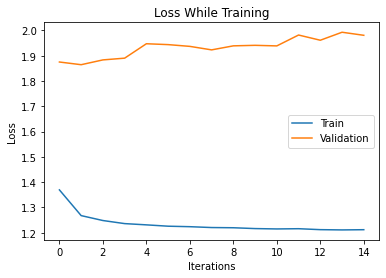

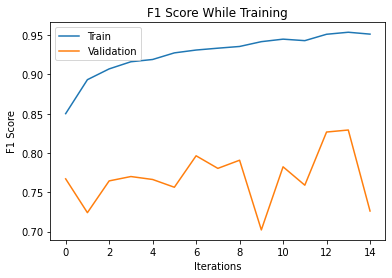

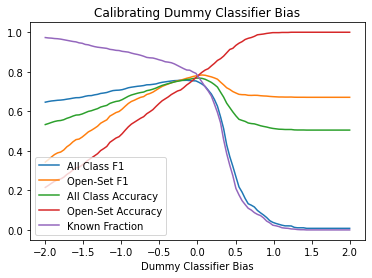

Results from test set using 95% bias (-1.5960):
0.6764182502444165
All Class F1: 0.6764
0.44119010102882567
Open-Set F1: 0.4412
tf.Tensor(0.57825, shape=(), dtype=float32)
All Class Accuracy: 0.5782
tf.Tensor(0.29764882, shape=(), dtype=float32)
Open-Set Accuracy: 0.2976
Epoch 1/35
781/781 [==============================] - 7s 7ms/step - f1: 0.5856 - loss: 1.8085 - val_loss: 0.0000e+00 - val_f1: 0.4300
Epoch 2/35
781/781 [==============================] - 5s 7ms/step - f1: 0.6144 - loss: 1.6142 - val_loss: 0.0000e+00 - val_f1: 0.4997
Epoch 3/35
781/781 [==============================] - 5s 6ms/step - f1: 0.6102 - loss: 1.5486 - val_loss: 0.0000e+00 - val_f1: 0.3852
Epoch 4/35
781/781 [==============================] - 5s 6ms/step - f1: 0.6119 - loss: 1.4776 - val_loss: 0.0000e+00 - val_f1: 0.5069
Epoch 5/35
781/781 [==============================] - 5s 6ms/step - f1: 0.6071 - loss: 1.5608 - val_loss: 0.0000e+00 - val_f1: 0.4968
Epoch 6/35
781/781 [==============================] - 5s 6

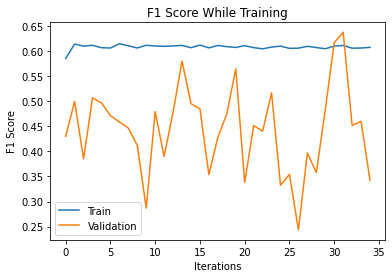

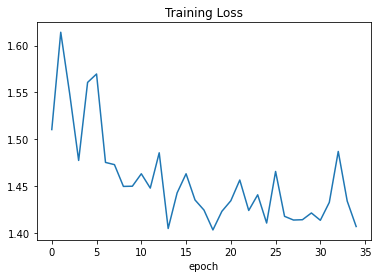

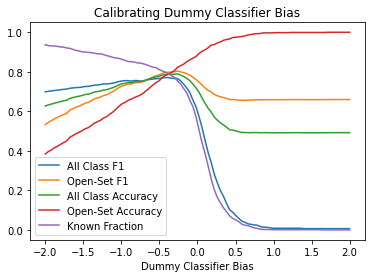

Results from test set using 95% bias (-2.0000):
0.6893193053120058
All Class F1: 0.6893
0.5078083874363923
Open-Set F1: 0.5078
tf.Tensor(0.60875, shape=(), dtype=float32)
All Class Accuracy: 0.6087
tf.Tensor(0.36193097, shape=(), dtype=float32)
Open-Set Accuracy: 0.3619
--------------------------------------
######################################
-------------gamma VALUE 0.25 ---------------
######################################
--------------------------------------
Epoch 1/15
1563/1563 [==============================] - 8s 4ms/step - loss: 1.3723 - f1: 0.8483 - val_loss: 1.8804 - val_f1: 0.7499
Epoch 2/15
1563/1563 [==============================] - 7s 4ms/step - loss: 1.2684 - f1: 0.8964 - val_loss: 1.8695 - val_f1: 0.7245
Epoch 3/15
1563/1563 [==============================] - 7s 4ms/step - loss: 1.2503 - f1: 0.9056 - val_loss: 1.8937 - val_f1: 0.7837
Epoch 4/15
1563/1563 [==============================] - 7s 4ms/step - loss: 1.2375 - f1: 0.9162 - val_loss: 1.9388 - val_f1: 0.7389

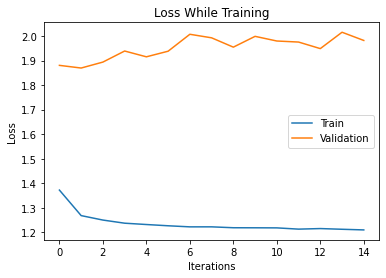

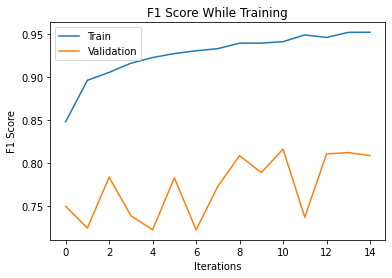

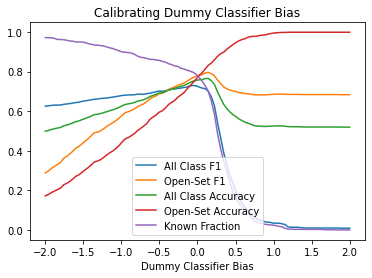

Results from test set using 95% bias (-1.5960):
0.6765592267599235
All Class F1: 0.6766
0.42810119439480865
Open-Set F1: 0.4281
tf.Tensor(0.573375, shape=(), dtype=float32)
All Class Accuracy: 0.5734
tf.Tensor(0.2846423, shape=(), dtype=float32)
Open-Set Accuracy: 0.2846
Epoch 1/35
781/781 [==============================] - 6s 7ms/step - f1: 0.5462 - loss: 1.8802 - val_loss: 0.0000e+00 - val_f1: 0.3531
Epoch 2/35
781/781 [==============================] - 5s 7ms/step - f1: 0.5777 - loss: 1.4737 - val_loss: 0.0000e+00 - val_f1: 0.3343
Epoch 3/35
781/781 [==============================] - 5s 7ms/step - f1: 0.5805 - loss: 1.6596 - val_loss: 0.0000e+00 - val_f1: 0.5122
Epoch 4/35
781/781 [==============================] - 5s 7ms/step - f1: 0.5881 - loss: 1.4547 - val_loss: 0.0000e+00 - val_f1: 0.5244
Epoch 5/35
781/781 [==============================] - 5s 7ms/step - f1: 0.5793 - loss: 1.4656 - val_loss: 0.0000e+00 - val_f1: 0.4498
Epoch 6/35
781/781 [==============================] - 5s 7

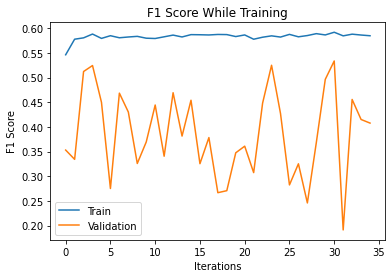

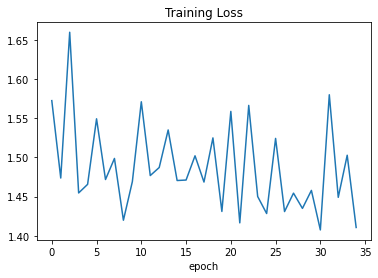

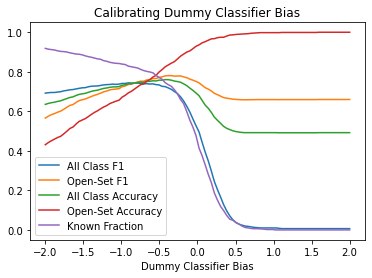

Results from test set using 95% bias (-2.0000):
0.7021587254723178
All Class F1: 0.7022
0.5794037492773969
Open-Set F1: 0.5794
tf.Tensor(0.6436875, shape=(), dtype=float32)
All Class Accuracy: 0.6437
tf.Tensor(0.43871936, shape=(), dtype=float32)
Open-Set Accuracy: 0.4387
--------------------------------------
######################################
-------------gamma VALUE 0.5 ---------------
######################################
--------------------------------------
Epoch 1/15
1563/1563 [==============================] - 8s 4ms/step - loss: 1.3722 - f1: 0.8490 - val_loss: 1.8882 - val_f1: 0.7242
Epoch 2/15
1563/1563 [==============================] - 7s 4ms/step - loss: 1.2670 - f1: 0.8949 - val_loss: 1.8509 - val_f1: 0.7992
Epoch 3/15
1563/1563 [==============================] - 7s 4ms/step - loss: 1.2487 - f1: 0.9087 - val_loss: 1.9116 - val_f1: 0.7793
Epoch 4/15
1563/1563 [==============================] - 7s 4ms/step - loss: 1.2374 - f1: 0.9137 - val_loss: 1.9299 - val_f1: 0.779

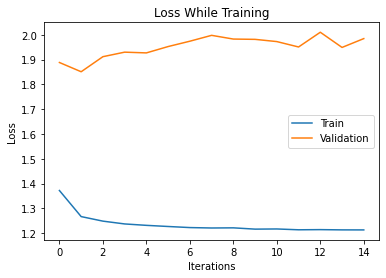

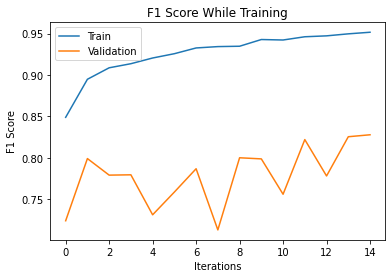

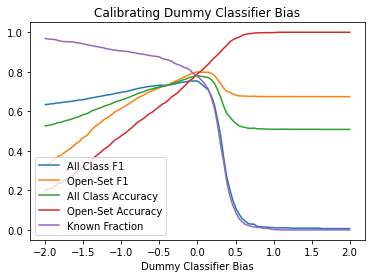

Results from test set using 95% bias (-1.6364):
0.6705933482417209
All Class F1: 0.6706
0.42151107744745314
Open-Set F1: 0.4215
tf.Tensor(0.57275, shape=(), dtype=float32)
All Class Accuracy: 0.5727
tf.Tensor(0.2783892, shape=(), dtype=float32)
Open-Set Accuracy: 0.2784
Epoch 1/35
781/781 [==============================] - 6s 7ms/step - f1: 0.4936 - loss: 1.9584 - val_loss: 0.0000e+00 - val_f1: 0.4023
Epoch 2/35
781/781 [==============================] - 5s 7ms/step - f1: 0.5431 - loss: 1.5166 - val_loss: 0.0000e+00 - val_f1: 0.3937
Epoch 3/35
781/781 [==============================] - 5s 7ms/step - f1: 0.5432 - loss: 1.4778 - val_loss: 0.0000e+00 - val_f1: 0.4318
Epoch 4/35
781/781 [==============================] - 6s 7ms/step - f1: 0.5467 - loss: 1.4367 - val_loss: 0.0000e+00 - val_f1: 0.3942
Epoch 5/35
781/781 [==============================] - 6s 7ms/step - f1: 0.5478 - loss: 1.6602 - val_loss: 0.0000e+00 - val_f1: 0.2928
Epoch 6/35
781/781 [==============================] - 5s 7m

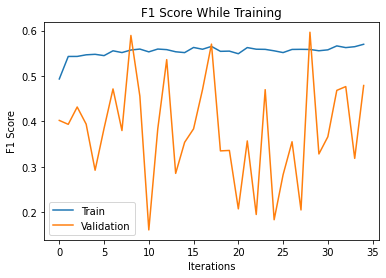

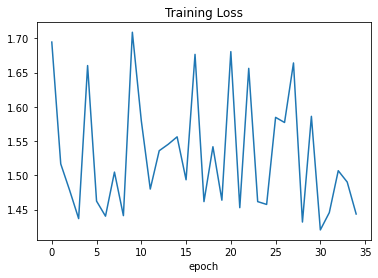

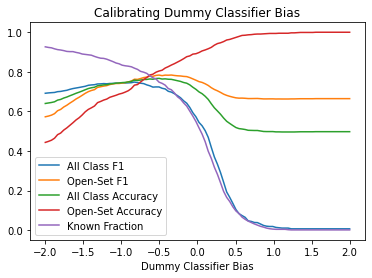

Results from test set using 95% bias (-2.0000):
0.7008630780111407
All Class F1: 0.7009
0.5615141955835963
Open-Set F1: 0.5615
tf.Tensor(0.6345, shape=(), dtype=float32)
All Class Accuracy: 0.6345
tf.Tensor(0.42296147, shape=(), dtype=float32)
Open-Set Accuracy: 0.4230
--------------------------------------
######################################
-------------gamma VALUE 0.75 ---------------
######################################
--------------------------------------
Epoch 1/15
1563/1563 [==============================] - 8s 5ms/step - loss: 1.3743 - f1: 0.8505 - val_loss: 1.8513 - val_f1: 0.7231
Epoch 2/15
1563/1563 [==============================] - 7s 4ms/step - loss: 1.2687 - f1: 0.8950 - val_loss: 1.9031 - val_f1: 0.7178
Epoch 3/15
1563/1563 [==============================] - 7s 4ms/step - loss: 1.2501 - f1: 0.9058 - val_loss: 1.8835 - val_f1: 0.6908
Epoch 4/15
1563/1563 [==============================] - 7s 4ms/step - loss: 1.2372 - f1: 0.9172 - val_loss: 1.8811 - val_f1: 0.7535


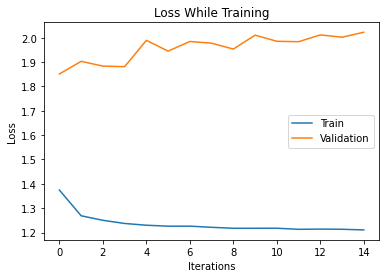

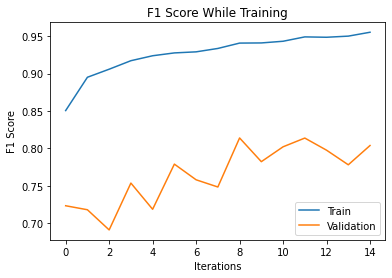

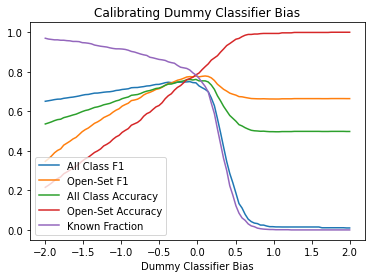

Results from test set using 95% bias (-1.5556):
0.682632178111578
All Class F1: 0.6826
0.473909480010928
Open-Set F1: 0.4739
tf.Tensor(0.5935625, shape=(), dtype=float32)
All Class Accuracy: 0.5936
tf.Tensor(0.32541272, shape=(), dtype=float32)
Open-Set Accuracy: 0.3254
Epoch 1/35
781/781 [==============================] - 7s 7ms/step - f1: 0.4506 - loss: 2.0667 - val_loss: 0.0000e+00 - val_f1: 0.2858
Epoch 2/35
781/781 [==============================] - 6s 7ms/step - f1: 0.5062 - loss: 1.8340 - val_loss: 0.0000e+00 - val_f1: 0.4077
Epoch 3/35
781/781 [==============================] - 6s 7ms/step - f1: 0.5121 - loss: 1.4778 - val_loss: 0.0000e+00 - val_f1: 0.3430
Epoch 4/35
781/781 [==============================] - 6s 7ms/step - f1: 0.5153 - loss: 1.5978 - val_loss: 0.0000e+00 - val_f1: 0.4998
Epoch 5/35
781/781 [==============================] - 6s 7ms/step - f1: 0.5215 - loss: 1.4643 - val_loss: 0.0000e+00 - val_f1: 0.4106
Epoch 6/35
781/781 [==============================] - 6s 7m

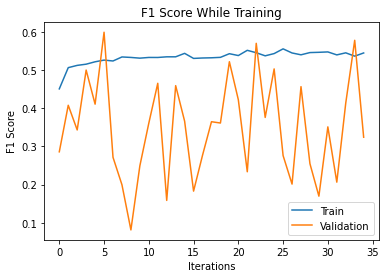

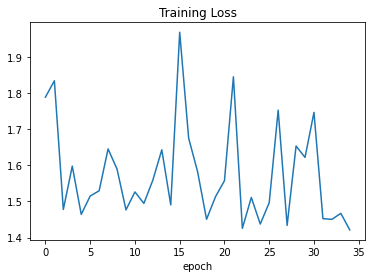

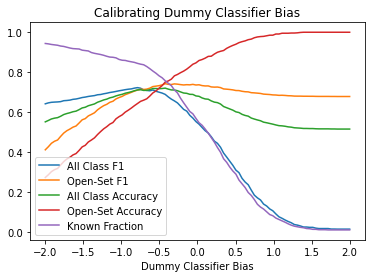

Results from test set using 95% bias (-2.0000):
0.6594202061920901
All Class F1: 0.6594
0.40300637427456953
Open-Set F1: 0.4030
tf.Tensor(0.55975, shape=(), dtype=float32)
All Class Accuracy: 0.5598
tf.Tensor(0.26488245, shape=(), dtype=float32)
Open-Set Accuracy: 0.2649
--------------------------------------
######################################
-------------gamma VALUE 0.9 ---------------
######################################
--------------------------------------
Epoch 1/15
1563/1563 [==============================] - 8s 5ms/step - loss: 1.3730 - f1: 0.8482 - val_loss: 1.8996 - val_f1: 0.6756
Epoch 2/15
1563/1563 [==============================] - 7s 5ms/step - loss: 1.2680 - f1: 0.8961 - val_loss: 1.8893 - val_f1: 0.7110
Epoch 3/15
1563/1563 [==============================] - 7s 5ms/step - loss: 1.2490 - f1: 0.9082 - val_loss: 1.9578 - val_f1: 0.7008
Epoch 4/15
1563/1563 [==============================] - 7s 5ms/step - loss: 1.2370 - f1: 0.9187 - val_loss: 1.9268 - val_f1: 0.7395

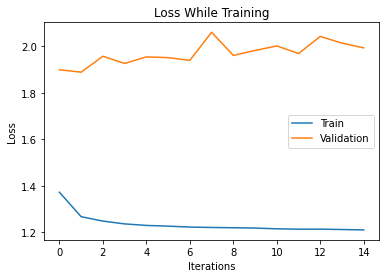

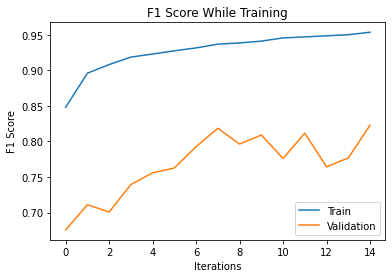

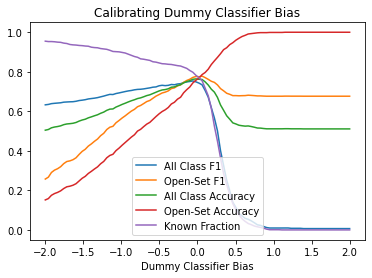

Results from test set using 95% bias (-1.8384):
0.6510177943614734
All Class F1: 0.6510
0.2966310599835662
Open-Set F1: 0.2966
tf.Tensor(0.5229375, shape=(), dtype=float32)
All Class Accuracy: 0.5229
tf.Tensor(0.1805903, shape=(), dtype=float32)
Open-Set Accuracy: 0.1806
Epoch 1/35
781/781 [==============================] - 7s 7ms/step - f1: 0.4480 - loss: 2.0933 - val_loss: 0.0000e+00 - val_f1: 0.2478
Epoch 2/35
781/781 [==============================] - 6s 7ms/step - f1: 0.4947 - loss: 1.5466 - val_loss: 0.0000e+00 - val_f1: 0.3734
Epoch 3/35
781/781 [==============================] - 6s 7ms/step - f1: 0.4954 - loss: 1.4781 - val_loss: 0.0000e+00 - val_f1: 0.5156
Epoch 4/35
781/781 [==============================] - 6s 7ms/step - f1: 0.4953 - loss: 1.6486 - val_loss: 0.0000e+00 - val_f1: 0.1480
Epoch 5/35
781/781 [==============================] - 6s 7ms/step - f1: 0.5047 - loss: 1.4878 - val_loss: 0.0000e+00 - val_f1: 0.5686
Epoch 6/35
781/781 [==============================] - 6s 7

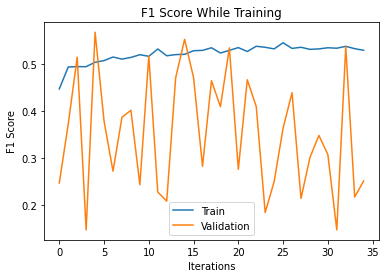

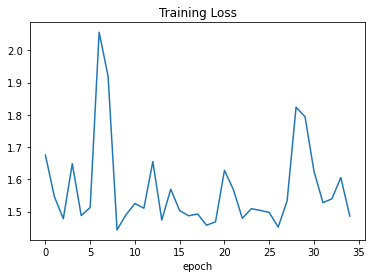

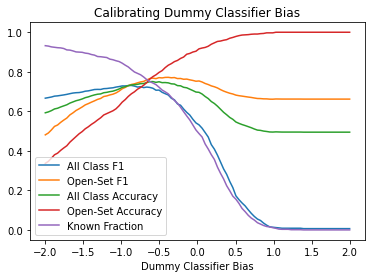

Results from test set using 95% bias (-2.0000):
0.6750910221116379
All Class F1: 0.6751
0.4766139071669927
Open-Set F1: 0.4766
tf.Tensor(0.5903125, shape=(), dtype=float32)
All Class Accuracy: 0.5903
tf.Tensor(0.3351676, shape=(), dtype=float32)
Open-Set Accuracy: 0.3352
--------------------------------------
######################################
-------------gamma VALUE 1.0 ---------------
######################################
--------------------------------------
Epoch 1/15
1563/1563 [==============================] - 8s 5ms/step - loss: 1.3750 - f1: 0.8481 - val_loss: 1.8536 - val_f1: 0.7259
Epoch 2/15
1563/1563 [==============================] - 7s 5ms/step - loss: 1.2688 - f1: 0.8935 - val_loss: 1.8609 - val_f1: 0.7047
Epoch 3/15
1563/1563 [==============================] - 7s 5ms/step - loss: 1.2499 - f1: 0.9072 - val_loss: 1.8675 - val_f1: 0.7502
Epoch 4/15
1563/1563 [==============================] - 7s 5ms/step - loss: 1.2381 - f1: 0.9145 - val_loss: 1.9081 - val_f1: 0.7593

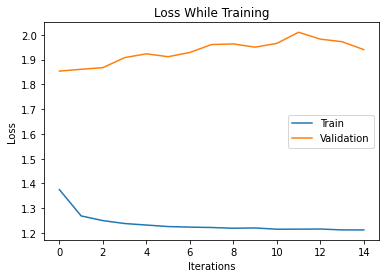

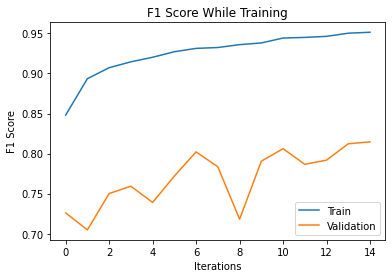

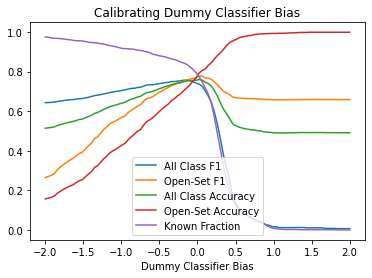

Results from test set using 95% bias (-1.4343):
0.672019073474668
All Class F1: 0.6720
0.42678137273237327
Open-Set F1: 0.4268
tf.Tensor(0.5725, shape=(), dtype=float32)
All Class Accuracy: 0.5725
tf.Tensor(0.2853927, shape=(), dtype=float32)
Open-Set Accuracy: 0.2854
Epoch 1/35
781/781 [==============================] - 7s 8ms/step - f1: 0.4288 - loss: 2.1690 - val_loss: 0.0000e+00 - val_f1: 0.4985
Epoch 2/35
781/781 [==============================] - 6s 7ms/step - f1: 0.4923 - loss: 2.0774 - val_loss: 0.0000e+00 - val_f1: 0.4987
Epoch 3/35
781/781 [==============================] - 6s 8ms/step - f1: 0.4833 - loss: 1.6411 - val_loss: 0.0000e+00 - val_f1: 0.6156
Epoch 4/35
781/781 [==============================] - 6s 7ms/step - f1: 0.4974 - loss: 1.4929 - val_loss: 0.0000e+00 - val_f1: 0.3895
Epoch 5/35
781/781 [==============================] - 6s 7ms/step - f1: 0.4907 - loss: 1.7131 - val_loss: 0.0000e+00 - val_f1: 0.1833
Epoch 6/35
781/781 [==============================] - 6s 7ms/

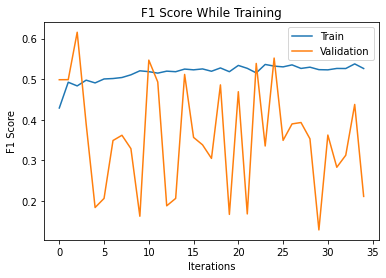

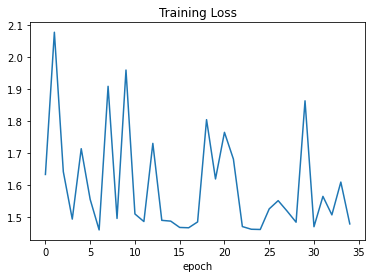

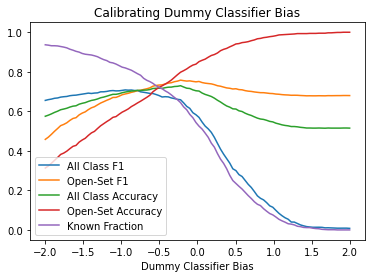

Results from test set using 95% bias (-2.0000):
0.6690422071682205
All Class F1: 0.6690
0.437838333792091
Open-Set F1: 0.4378
tf.Tensor(0.572125, shape=(), dtype=float32)
All Class Accuracy: 0.5721
tf.Tensor(0.2983992, shape=(), dtype=float32)
Open-Set Accuracy: 0.2984


In [ ]:
metric_train_OSPLRM_abgg = {"All Class F1":[], "Open-Set F1":[], "All Class Accuracy":[], "Open-Set Accuracy":[]}
metric_train_OSPWDPLSM_abgg = {"All Class F1":[], "Open-Set F1":[], "All Class Accuracy":[], "Open-Set Accuracy":[]}

alpha_val = 1.0
for gamma_val in [.1, .25, .5, .75, .9, 1.0]:
      print("--------------------------------------")
      print("######################################")
      print('-------------gamma VALUE {} ---------------'.format(gamma_val))
      print("######################################")
      print("--------------------------------------")
      model = train_OSPLRM(
          X, y,
          num_classes=NUM_CLASSES,
          epochs=15,
          num_placeholders=50,
          pre_dim=300,
          post_dim=300,
          beta=0.75,
          plot=True,
      )

      bias = tune_OSPLRM_threshold(model, X_val, y_val)
      model.bias = bias
      
      y_test_open = modify_open_set_labels(y_test, OPEN_SET_LABELS)

      y_pred = model.predict(X_test)
      print('Results from test set using 95% bias ({:.4f}):'.format(bias))
      for metric in tuning_metrics:
          metric_func = tuning_metrics[metric]
          valueOfMetric = metric_func(y_test_open, y_pred)
          print(valueOfMetric)
          metric_train_OSPLRM_abgg[metric].append(valueOfMetric)
          print('{}: {:.4f}'.format(metric, valueOfMetric))



      # ----------------------------------- #



      model = train_OSPWDPLSM(
          X, y,
          num_classes=NUM_CLASSES,
          epochs=35,
          num_placeholders=5,
          pre_dim=100,
          post_dim=100,
          alpha=alpha_val,
          beta=1.0,
          gamma=gamma_val,
          plot=True,
      )


      bias = tune_OSPLRM_threshold(model, X_val, y_val, OPEN_SET_LABELS)
      model.bias = bias

      y_test_open = modify_open_set_labels(y_test, OPEN_SET_LABELS)

      y_pred = model.predict(X_test)
      print('Results from test set using 95% bias ({:.4f}):'.format(bias))
      for metric in tuning_metrics:
          metric_func = tuning_metrics[metric]
          valueOfMetric = metric_func(y_test_open, y_pred)
          print(valueOfMetric)
          metric_train_OSPWDPLSM_abgg[metric].append(valueOfMetric)
          print('{}: {:.4f}'.format(metric, valueOfMetric))




In [ ]:
print(metric_train_OSPLRM_abgg)
print(metric_train_OSPWDPLSM_abgg)
print("\n----------------------------\n")
headers = [.1, .25, .5, .75, .9, 1.0]
print(f'{"Score Type": <20}{headers[0]: <20}{headers[1]: <20}{headers[2]: <20}{headers[3]: <20}{headers[4]: <20}{headers[5]: <20}')
for key, value in metric_train_OSPLRM_abgg.items():
    print(f'{key: <20}{value[0]: <20}{value[1]: <20}{value[2]: <20}{value[3]: <20}{value[4]: <20}{value[5]: <20}')

print("\n\n")
print(f'{"Score Type": <20}{headers[0]: <20}{headers[1]: <20}{headers[2]: <20}{headers[3]: <20}{headers[4]: <20}{headers[5]: <20}')
for key, value in metric_train_OSPWDPLSM_abgg.items():
    print(f'{key: <20}{value[0]: <20}{value[1]: <20}{value[2]: <20}{value[3]: <20}{value[4]: <20}{value[5]: <20}')


{'All Class F1': [0.6764182502444165, 0.6765592267599235, 0.6705933482417209, 0.682632178111578, 0.6510177943614734, 0.672019073474668], 'Open-Set F1': [0.44119010102882567, 0.42810119439480865, 0.42151107744745314, 0.473909480010928, 0.2966310599835662, 0.42678137273237327], 'All Class Accuracy': [<tf.Tensor: shape=(), dtype=float32, numpy=0.57825>, <tf.Tensor: shape=(), dtype=float32, numpy=0.573375>, <tf.Tensor: shape=(), dtype=float32, numpy=0.57275>, <tf.Tensor: shape=(), dtype=float32, numpy=0.5935625>, <tf.Tensor: shape=(), dtype=float32, numpy=0.5229375>, <tf.Tensor: shape=(), dtype=float32, numpy=0.5725>], 'Open-Set Accuracy': [<tf.Tensor: shape=(), dtype=float32, numpy=0.29764882>, <tf.Tensor: shape=(), dtype=float32, numpy=0.2846423>, <tf.Tensor: shape=(), dtype=float32, numpy=0.2783892>, <tf.Tensor: shape=(), dtype=float32, numpy=0.32541272>, <tf.Tensor: shape=(), dtype=float32, numpy=0.1805903>, <tf.Tensor: shape=(), dtype=float32, numpy=0.2853927>]}
{'All Class F1': [0.68

In [30]:
def metric_defined_by_us(y_test_value, y_pred_value):
  from statistics import mean
  import numpy as np
  y_test_open_np = np.asarray(y_test_value)
  y_pred_np = np.asarray(y_pred_value)

  precisions = []
  recalls = []
  for label_chosen in set(y_test_value.numpy().astype(int).tolist()):
      TP = np.sum(np.logical_and(y_test_open_np == label_chosen , y_pred_np == label_chosen))
      TN = np.sum(np.logical_and(y_test_open_np != label_chosen , y_pred_np != label_chosen))
      FP = np.sum(np.logical_and(y_test_open_np != label_chosen , y_pred_np == label_chosen))
      FN = np.sum(np.logical_and(y_test_open_np == label_chosen , y_pred_np != label_chosen))
      # print ("TP: "+str(TP)+", FP: "+str(FP)+", TN: "+str(TN)+", FN: "+str(FN))
      if(TP == 0):
            P = 0
            R = 0
      else:
          P = round(100*TP/(TP + FP), 2)
          R = round(100*TP/(TP + FN),2)
      precisions.append(P)
      recalls.append(R)


  precision_known, recall_known = round(mean(precisions),2), round(mean(recalls),2)
  f1_known = round(2*precision_known*recall_known/(precision_known + recall_known),2)

  print("------------- KNOWN -------------")
  print("Precision: ",precision_known)
  print("Recall: ",recall_known)
  print("F1-Score: ",f1_known)

    
  precisionsOpen = []
  recallsOpen = []
  for label_chosen in [-1]:
      TP = np.sum(np.logical_and(y_test_open_np == label_chosen , y_pred_np == -1))
      TN = np.sum(np.logical_and(y_test_open_np != label_chosen , y_pred_np != -1))
      FP = np.sum(np.logical_and(y_test_open_np != label_chosen , y_pred_np == -1))
      FN = np.sum(np.logical_and(y_test_open_np == label_chosen , y_pred_np != -1))
      # print ("TP: "+str(TP)+", FP: "+str(FP)+", TN: "+str(TN)+", FN: "+str(FN))
      if(TP == 0):
            P = 0
            R = 0
      else:
          P = round(100*TP/(TP + FP), 2)
          R = round(100*TP/(TP + FN),2)
      precisionsOpen.append(P)
      recallsOpen.append(R)

  precision_ood, recall_ood = round(mean(precisionsOpen),2), round(mean(recallsOpen),2)
  f1_ood = round(2*precision_ood*recall_ood/(precision_ood + recall_ood),2)

  print("------------- OPEN -------------")
  print("Precision: ",precision_ood)
  print("Recall: ",recall_ood)
  print("F1-Score: ",f1_ood)



  precisions.append(precision_ood)
  recalls.append(recall_ood)



  precision, recall = round(mean(precisions),2), round(mean(recalls),2)
  f1 = round(2*precision*recall/(precision + recall),2)

  print("------------- OVERALL -------------")
  print("Precision: ",precision)
  print("Recall: ",recall)
  print("F1-Score: ",f1)

#FIRST ATTEMPT AT FINE TUNING THE MODEL

Epoch 1/15
1563/1563 [==============================] - 7s 4ms/step - loss: 1.3734 - f1: 0.8465 - val_loss: 1.8052 - val_f1: 0.7320
Epoch 2/15
1563/1563 [==============================] - 7s 4ms/step - loss: 1.2671 - f1: 0.8960 - val_loss: 1.8413 - val_f1: 0.7674
Epoch 3/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2484 - f1: 0.9069 - val_loss: 1.8616 - val_f1: 0.7002
Epoch 4/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2376 - f1: 0.9151 - val_loss: 1.9040 - val_f1: 0.7174
Epoch 5/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2333 - f1: 0.9205 - val_loss: 1.9134 - val_f1: 0.7964
Epoch 6/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2261 - f1: 0.9267 - val_loss: 1.9150 - val_f1: 0.7704
Epoch 7/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2234 - f1: 0.9310 - val_loss: 1.8991 - val_f1: 0.7445
Epoch 8/15
1563/1563 [==============================] - 6s 4ms/step - loss: 

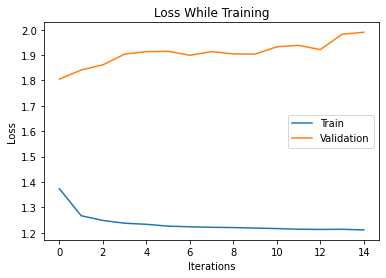

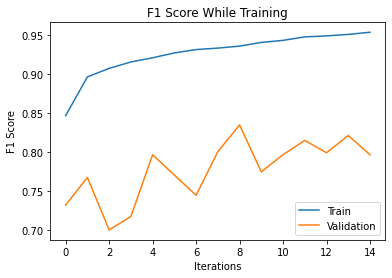

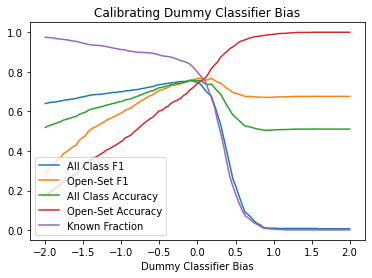

Results from test set using 95% bias (-1.5556):
All Class F1: 0.6681
Open-Set F1: 0.4091
All Class Accuracy: 0.5627
Open-Set Accuracy: 0.2696


##### METRICS DEFINED BY US #####
------------- KNOWN -------------
Precision:  57.47
Recall:  85.2
F1-Score:  68.64
------------- OPEN -------------
Precision:  84.78
Recall:  26.96
F1-Score:  40.91
------------- OVERALL -------------
Precision:  57.74
Recall:  84.62
F1-Score:  68.64
#################################


Epoch 1/35
781/781 [==============================] - 6s 7ms/step - f1: 0.5488 - loss: 1.8774 - val_loss: 0.0000e+00 - val_f1: 0.4335
Epoch 2/35
781/781 [==============================] - 5s 6ms/step - f1: 0.5791 - loss: 1.6084 - val_loss: 0.0000e+00 - val_f1: 0.4103
Epoch 3/35
781/781 [==============================] - 5s 7ms/step - f1: 0.5831 - loss: 1.8088 - val_loss: 0.0000e+00 - val_f1: 0.3829
Epoch 4/35
781/781 [==============================] - 5s 7ms/step - f1: 0.5851 - loss: 1.7615 - val_loss: 0.0000e+00 - val_f1: 0.470

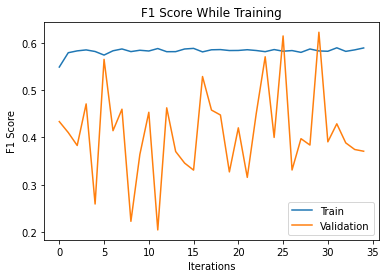

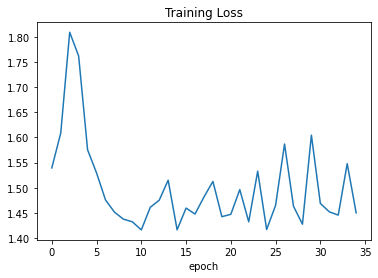

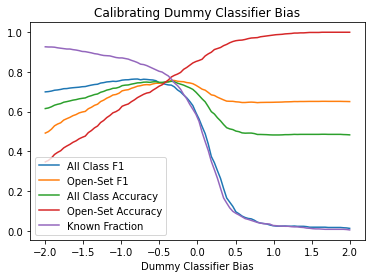

Results from test set using 95% bias (-2.0000):
All Class F1: 0.6861
Open-Set F1: 0.5157
All Class Accuracy: 0.6086
Open-Set Accuracy: 0.3734


##### METRICS DEFINED BY US #####
------------- KNOWN -------------
Precision:  60.35
Recall:  84.1
F1-Score:  70.27
------------- OPEN -------------
Precision:  83.35
Recall:  37.34
F1-Score:  51.57
------------- OVERALL -------------
Precision:  60.57
Recall:  83.64
F1-Score:  70.26
#################################


In [32]:
metric_train_OSPLRM_abgg = {"All Class F1":[], "Open-Set F1":[], "All Class Accuracy":[], "Open-Set Accuracy":[]}
metric_train_OSPWDPLSM_abgg = {"All Class F1":[], "Open-Set F1":[], "All Class Accuracy":[], "Open-Set Accuracy":[]}


model = train_OSPLRM(
    X, y,
    num_classes=NUM_CLASSES,
    epochs=15,
    num_placeholders=50,
    pre_dim=300,
    post_dim=300,
    beta=0.75,
    plot=True,
)

bias = tune_OSPLRM_threshold(model, X_val, y_val)
model.bias = bias

y_test_open = modify_open_set_labels(y_test, OPEN_SET_LABELS)

y_pred = model.predict(X_test)
print('Results from test set using 95% bias ({:.4f}):'.format(bias))
for metric in tuning_metrics:
    metric_func = tuning_metrics[metric]
    valueOfMetric = metric_func(y_test_open, y_pred)
    metric_train_OSPLRM_abgg[metric].append(valueOfMetric)
    print('{}: {:.4f}'.format(metric, valueOfMetric))

print("\n\n##### METRICS DEFINED BY US #####")
metric_defined_by_us(y_test_open, y_pred)
print("#################################\n\n")

# ----------------------------------- #



model = train_OSPWDPLSM(
    X, y,
    num_classes=NUM_CLASSES,
    epochs=35,
    num_placeholders=5,
    pre_dim=100,
    post_dim=100,
    alpha=1.0,
    beta=1.0,
    gamma=0.25,
    plot=True,
)


bias = tune_OSPLRM_threshold(model, X_val, y_val, OPEN_SET_LABELS)
model.bias = bias
y_test_open = modify_open_set_labels(y_test, OPEN_SET_LABELS)

y_pred = model.predict(X_test)
print('Results from test set using 95% bias ({:.4f}):'.format(bias))
for metric in tuning_metrics:
    metric_func = tuning_metrics[metric]
    valueOfMetric = metric_func(y_test_open, y_pred)
    metric_train_OSPWDPLSM_abgg[metric].append(valueOfMetric)
    print('{}: {:.4f}'.format(metric, valueOfMetric))



print("\n\n##### METRICS DEFINED BY US #####")
metric_defined_by_us(y_test_open, y_pred)
print("#################################")